# TASK 1

Step-by-Step Outline:

1. Load and Preprocess the Dataset
Normalize images to [0, 1]

Convert .tif files to RGB

Flatten images to 1D vectors

Create train / val / test splits

2. Build the Perceptron Model
Input size = flattened image size

Output size = number of classes (16)

Use sigmoid activation (as per your assignment — although softmax is typical for multi-class)

Use cross-entropy loss

3. Train
Use SGD optimizer, lr = 0.01

20 epochs

4. Analysis
Plot:

Training loss & accuracy

Validation loss & accuracy

Compute confusion matrix on test set

Try learning rates: 0.001, 0.01, 0.1 → Compare convergence



## Data set Load and Preprocessing

In [1]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from PIL import Image

# Convert tif to RGB and normalize to [0,1], flatten later
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Optional, if you want grayscale
    transforms.Resize((64, 64)),  # To speed up training
    transforms.ToTensor(),  # Converts to [0, 1]
    transforms.Lambda(lambda x: x.view(-1))  # Flatten to 1D
])

data_path = "/kaggle/input/rvl-cdip-small/data"

# Load as ImageFolder
dataset = datasets.ImageFolder(root=data_path, transform=transform)
class_names = dataset.classes

# Split into train/val/test
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)
test_loader = DataLoader(test_ds, batch_size=64)

input_size = 64 * 64  # since we resized
output_size = len(class_names)


In [6]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from PIL import Image
from collections import defaultdict
import random

# Your existing transform
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

data_path = "/kaggle/input/rvl-cdip-small/data"

# Load as ImageFolder (this initially loads ALL paths, but we'll subset it)
full_dataset = datasets.ImageFolder(root=data_path, transform=transform)
class_names = full_dataset.classes
output_size = len(class_names) # 16 classes

# --- Create a subset with 100 images per class ---
subset_indices = []
class_counts = defaultdict(int) # To track how many images we've taken per class

# Map original targets (integers) to actual paths, then filter
# It's more efficient to iterate through full_dataset.samples directly
# full_dataset.samples is a list of (image_path, class_index) tuples
for i, (path, class_idx) in enumerate(full_dataset.samples):
    if class_counts[class_idx] < 100:
        subset_indices.append(i)
        class_counts[class_idx] += 1
    # Optional: if all classes have 100 images, we can break early
    if all(count >= 100 for count in class_counts.values()) and len(class_counts) == output_size:
        break

# Shuffle the selected indices to ensure randomness before creating the subset
random.shuffle(subset_indices)

# Create the new, smaller dataset using Subset
dataset = Subset(full_dataset, subset_indices)

print(f"Original dataset size: {len(full_dataset)}")
print(f"Subset dataset size: {len(dataset)} (should be {output_size * 100})")

# Split into train/val/test from the subset
# Adjust percentages if needed for smaller dataset (e.g., more for training)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Use random_split on the `dataset` (the subset)
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)
test_loader = DataLoader(test_ds, batch_size=64)

input_size = 64 * 64
output_size = len(class_names) # Still 16 classes

Original dataset size: 47996
Subset dataset size: 1600 (should be 1600)


--- Training with LR = 0.01 ---
LR 0.01: Epoch [1/20] Train Loss: 0.2907 Train Acc: 0.0625 Val Loss: 0.2414 Val Acc: 0.0500
LR 0.01: Epoch [2/20] Train Loss: 0.2412 Train Acc: 0.0688 Val Loss: 0.2408 Val Acc: 0.0500
LR 0.01: Epoch [3/20] Train Loss: 0.2402 Train Acc: 0.0777 Val Loss: 0.2405 Val Acc: 0.0542
LR 0.01: Epoch [4/20] Train Loss: 0.2398 Train Acc: 0.0723 Val Loss: 0.2399 Val Acc: 0.0792
LR 0.01: Epoch [5/20] Train Loss: 0.2390 Train Acc: 0.0750 Val Loss: 0.2394 Val Acc: 0.0875
LR 0.01: Epoch [6/20] Train Loss: 0.2386 Train Acc: 0.0893 Val Loss: 0.2372 Val Acc: 0.0792
LR 0.01: Epoch [7/20] Train Loss: 0.2378 Train Acc: 0.1062 Val Loss: 0.2380 Val Acc: 0.0958
LR 0.01: Epoch [8/20] Train Loss: 0.2377 Train Acc: 0.1089 Val Loss: 0.2368 Val Acc: 0.1250
LR 0.01: Epoch [9/20] Train Loss: 0.2368 Train Acc: 0.1357 Val Loss: 0.2363 Val Acc: 0.1167
LR 0.01: Epoch [10/20] Train Loss: 0.2365 Train Acc: 0.1125 Val Loss: 0.2351 Val Acc: 0.1417
LR 0.01: Epoch [11/20] Train Loss: 0.2358 Train

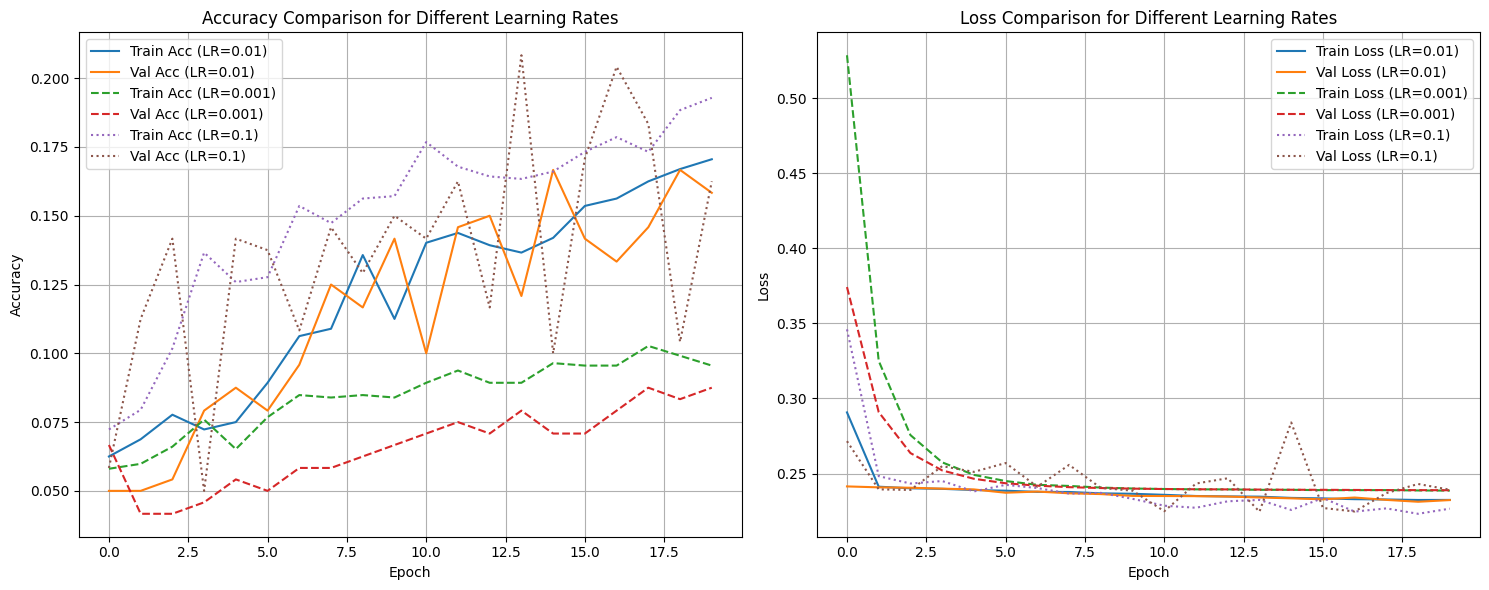

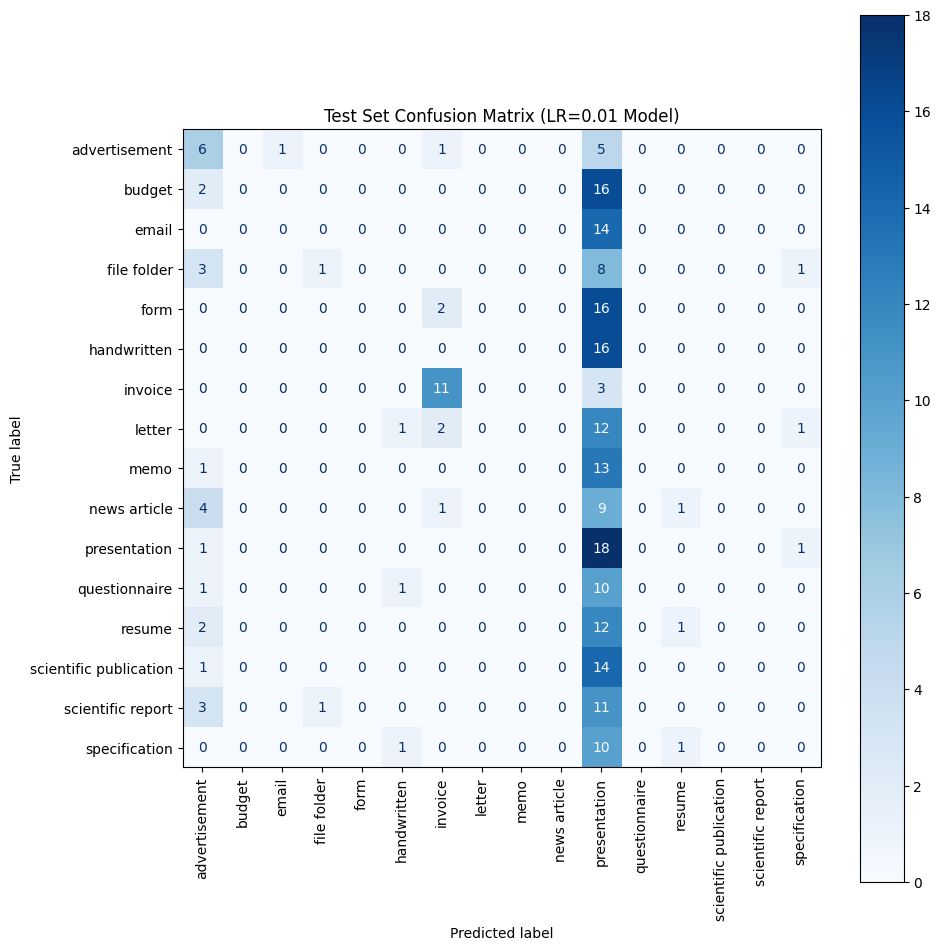


--- Summary ---
LR 0.01: Final Val Acc = 0.1583, Training Time = 181.42s
LR 0.001: Final Val Acc = 0.0875, Training Time = 172.92s
LR 0.1: Final Val Acc = 0.1625, Training Time = 174.54s


In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from PIL import Image
from collections import defaultdict
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import time

# --- Data Loading and Preprocessing (100 images per class) ---

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

data_path = "/kaggle/input/rvl-cdip-small/data"

full_dataset = datasets.ImageFolder(root=data_path, transform=transform)
class_names = full_dataset.classes
output_size = len(class_names)

subset_indices = []
class_counts = defaultdict(int)

for i, (path, class_idx) in enumerate(full_dataset.samples):
    if class_counts[class_idx] < 100:
        subset_indices.append(i)
        class_counts[class_idx] += 1
    if all(count >= 100 for count in class_counts.values()) and len(class_counts) == output_size:
        break

random.shuffle(subset_indices)
dataset = Subset(full_dataset, subset_indices)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)
test_loader = DataLoader(test_ds, batch_size=64)

input_size = 64 * 64

# --- Task 1: Single-Layer Perceptron Training ---

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SingleLayerPerceptron(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SingleLayerPerceptron, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.fc(x))

def to_one_hot(labels, num_classes):
    return torch.eye(num_classes, device=labels.device)[labels]

def train_and_evaluate(model, criterion, optimizer, train_loader, val_loader, num_epochs, log_prefix=""):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            labels_one_hot = to_one_hot(labels, output_size).to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels_one_hot)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                labels_one_hot = to_one_hot(labels, output_size).to(device)

                outputs = model(images)
                loss = criterion(outputs, labels_one_hot)
                val_loss += loss.item()

                predicted = torch.argmax(outputs, dim=1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_correct / val_total)

        print(f"{log_prefix}Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_losses[-1]:.4f} Train Acc: {train_accuracies[-1]:.4f} Val Loss: {val_losses[-1]:.4f} Val Acc: {val_accuracies[-1]:.4f}")
    return train_losses, val_losses, train_accuracies, val_accuracies

# Baseline LR = 0.01
print("--- Training with LR = 0.01 ---")
model_0_01 = SingleLayerPerceptron(input_size=input_size, num_classes=output_size).to(device)
criterion_0_01 = nn.BCELoss()
optimizer_0_01 = optim.SGD(model_0_01.parameters(), lr=0.01)
start_time_0_01 = time.time()
train_losses_0_01, val_losses_0_01, train_accuracies_0_01, val_accuracies_0_01 = \
    train_and_evaluate(model_0_01, criterion_0_01, optimizer_0_01, train_loader, val_loader, 20, "LR 0.01: ")
time_0_01 = time.time() - start_time_0_01

# Test LR = 0.001
print("\n--- Training with LR = 0.001 ---")
model_0_001 = SingleLayerPerceptron(input_size=input_size, num_classes=output_size).to(device)
criterion_0_001 = nn.BCELoss()
optimizer_0_001 = optim.SGD(model_0_001.parameters(), lr=0.001)
start_time_0_001 = time.time()
train_losses_0_001, val_losses_0_001, train_accuracies_0_001, val_accuracies_0_001 = \
    train_and_evaluate(model_0_001, criterion_0_001, optimizer_0_001, train_loader, val_loader, 20, "LR 0.001: ")
time_0_001 = time.time() - start_time_0_001

# Test LR = 0.1
print("\n--- Training with LR = 0.1 ---")
model_0_1 = SingleLayerPerceptron(input_size=input_size, num_classes=output_size).to(device)
criterion_0_1 = nn.BCELoss()
optimizer_0_1 = optim.SGD(model_0_1.parameters(), lr=0.1)
start_time_0_1 = time.time()
train_losses_0_1, val_losses_0_1, train_accuracies_0_1, val_accuracies_0_1 = \
    train_and_evaluate(model_0_1, criterion_0_1, optimizer_0_1, train_loader, val_loader, 20, "LR 0.1: ")
time_0_1 = time.time() - start_time_0_1

# Plot Accuracy & Loss
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(train_accuracies_0_01, label="Train Acc (LR=0.01)")
plt.plot(val_accuracies_0_01, label="Val Acc (LR=0.01)")
plt.plot(train_accuracies_0_001, label="Train Acc (LR=0.001)", linestyle='--')
plt.plot(val_accuracies_0_001, label="Val Acc (LR=0.001)", linestyle='--')
plt.plot(train_accuracies_0_1, label="Train Acc (LR=0.1)", linestyle=':')
plt.plot(val_accuracies_0_1, label="Val Acc (LR=0.1)", linestyle=':')
plt.title("Accuracy Comparison for Different Learning Rates")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_losses_0_01, label="Train Loss (LR=0.01)")
plt.plot(val_losses_0_01, label="Val Loss (LR=0.01)")
plt.plot(train_losses_0_001, label="Train Loss (LR=0.001)", linestyle='--')
plt.plot(val_losses_0_001, label="Val Loss (LR=0.001)", linestyle='--')
plt.plot(train_losses_0_1, label="Train Loss (LR=0.1)", linestyle=':')
plt.plot(val_losses_0_1, label="Val Loss (LR=0.1)", linestyle=':')
plt.title("Loss Comparison for Different Learning Rates")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Confusion Matrix (using the baseline LR=0.01 model)
best_model_for_cm = model_0_01
best_model_for_cm.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = best_model_for_cm(images)
        predicted = torch.argmax(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(xticks_rotation=90, cmap='Blues', ax=ax)
plt.title("Test Set Confusion Matrix (LR=0.01 Model)")
plt.tight_layout()
plt.show()

print("\n--- Summary ---")
print(f"LR 0.01: Final Val Acc = {val_accuracies_0_01[-1]:.4f}, Training Time = {time_0_01:.2f}s")
print(f"LR 0.001: Final Val Acc = {val_accuracies_0_001[-1]:.4f}, Training Time = {time_0_001:.2f}s")
print(f"LR 0.1: Final Val Acc = {val_accuracies_0_1[-1]:.4f}, Training Time = {time_0_1:.2f}s")

# TASK 2



--- Starting Task 2: Multi-Layer Perceptron (MLP) with Backpropagation ---
--- Task 2: Manual Backpropagation for 1 Epoch (Illustrative) ---
Manual Backprop - Initial Loss: 2.7791
Manual backpropagation (conceptual, using autograd) for 1 epoch finished.

--- Task 2: Training MLP with Autograd (ReLU, Sigmoid, Tanh) ---

--- Training MLP with ReLU Activation (LR=0.01) ---
MLP ReLU: Epoch [1/20] Train Loss: 2.7801 Train Acc: 0.0625 Val Loss: 2.7691 Val Acc: 0.0917
MLP ReLU: Epoch [2/20] Train Loss: 2.7741 Train Acc: 0.0830 Val Loss: 2.7489 Val Acc: 0.1333
MLP ReLU: Epoch [3/20] Train Loss: 2.7558 Train Acc: 0.1143 Val Loss: 2.7259 Val Acc: 0.1000
MLP ReLU: Epoch [4/20] Train Loss: 2.7213 Train Acc: 0.1313 Val Loss: 2.6864 Val Acc: 0.1667
MLP ReLU: Epoch [5/20] Train Loss: 2.6732 Train Acc: 0.1304 Val Loss: 2.6556 Val Acc: 0.1250
MLP ReLU: Epoch [6/20] Train Loss: 2.6466 Train Acc: 0.1437 Val Loss: 2.5999 Val Acc: 0.1583
MLP ReLU: Epoch [7/20] Train Loss: 2.6127 Train Acc: 0.1491 Val Los

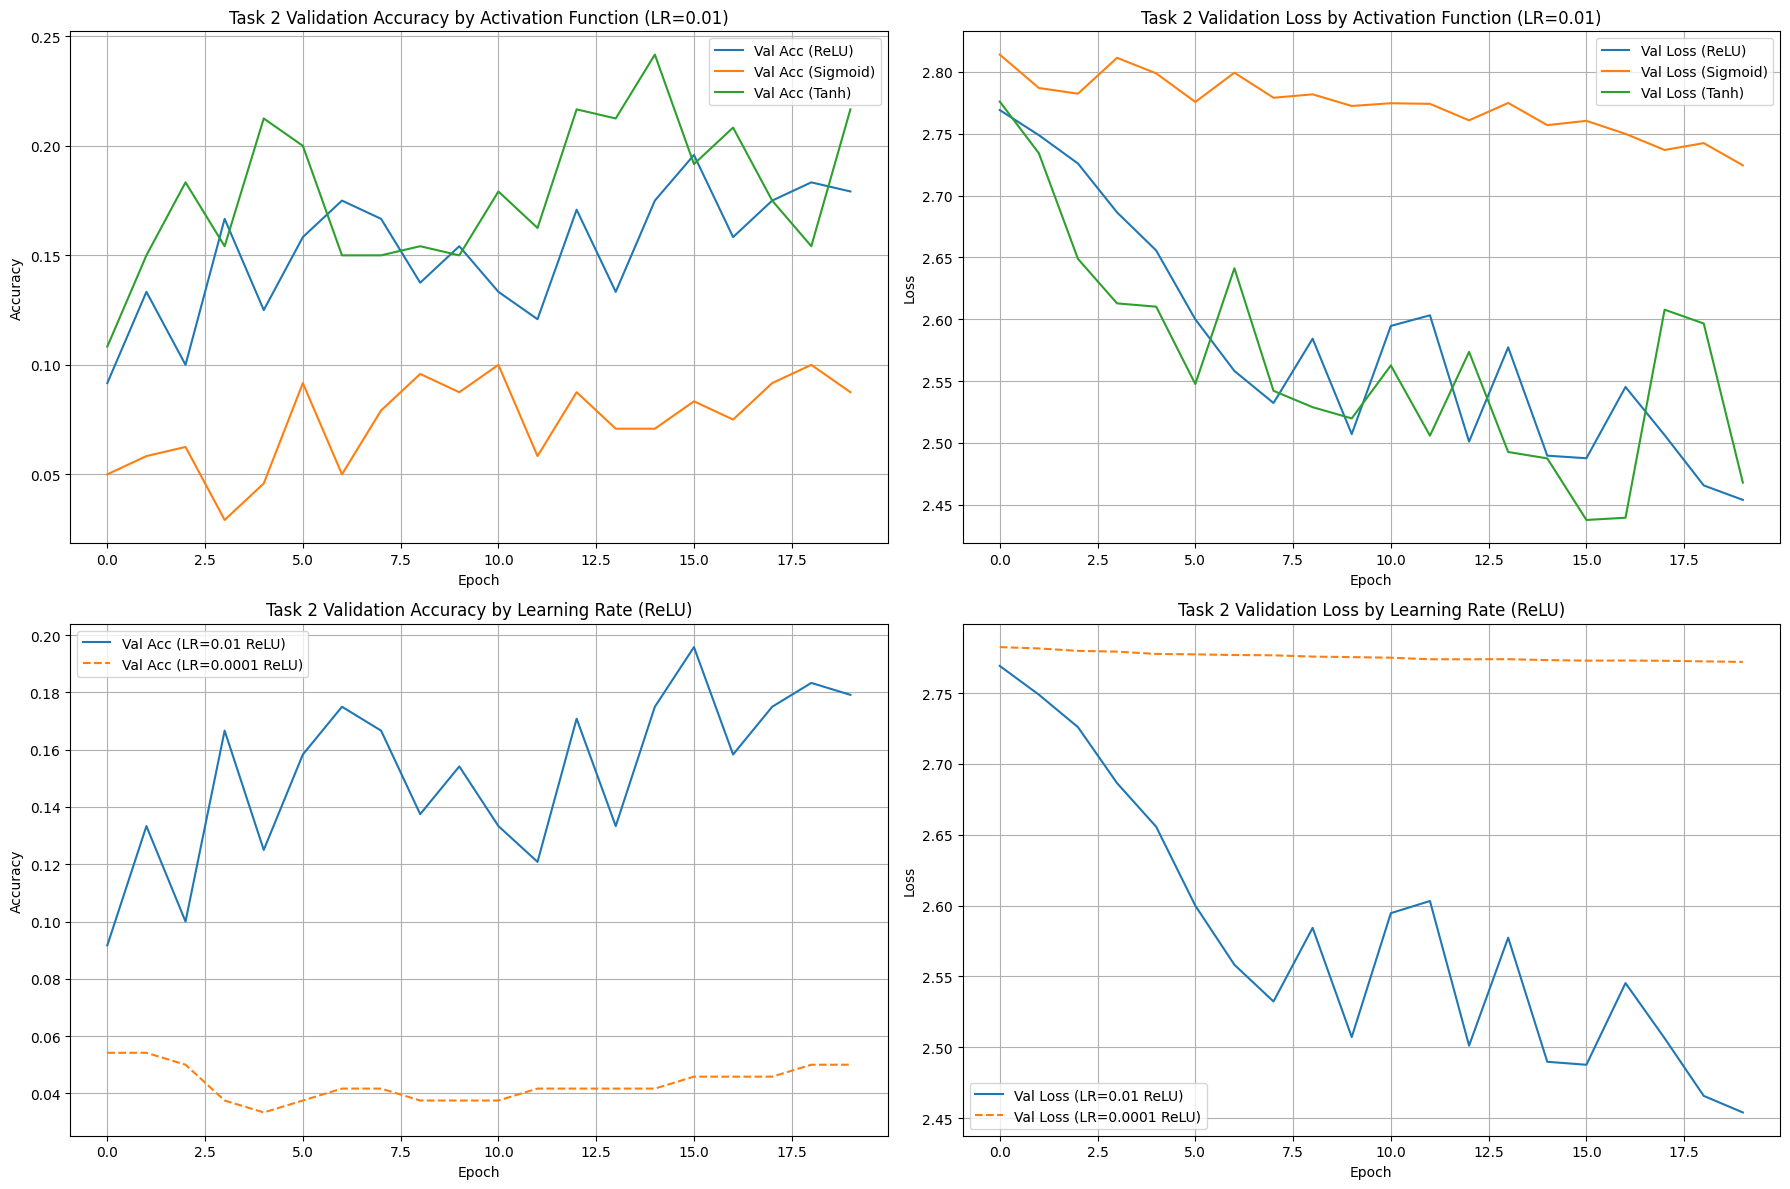


--- Task 2 Summary ---
ReLU MLP (LR=0.01): Final Val Acc = 0.1792, Time = 169.00s
Sigmoid MLP (LR=0.01): Final Val Acc = 0.0875, Time = 168.57s
Tanh MLP (LR=0.01): Final Val Acc = 0.2167, Time = 168.46s
ReLU MLP (LR=0.0001): Final Val Acc = 0.0500, Time = 168.07s


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import time

# IMPORTANT: Ensure the data loading and preprocessing (100 images per class)
# from the beginning of our combined script has been executed.
# This code assumes the following variables are already defined:
# train_loader, val_loader, test_loader, input_size, output_size, class_names, device

print("\n\n--- Starting Task 2: Multi-Layer Perceptron (MLP) with Backpropagation ---")

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes, activation_fn=nn.ReLU()):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.activation1 = activation_fn
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.activation2 = activation_fn
        self.fc3 = nn.Linear(hidden_size2, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = self.fc3(x)
        return x # Raw logits for CrossEntropyLoss

def train_and_evaluate_mlp_task2(model, criterion, optimizer, train_loader, val_loader, num_epochs, log_prefix=""):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_correct / val_total)

        print(f"{log_prefix}Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_losses[-1]:.4f} Train Acc: {train_accuracies[-1]:.4f} Val Loss: {val_losses[-1]:.4f} Val Acc: {val_accuracies[-1]:.4f}")
    return train_losses, val_losses, train_accuracies, val_accuracies

# --- Part 1: Manual Backpropagation for One Epoch (Illustrative) ---
print("--- Task 2: Manual Backpropagation for 1 Epoch (Illustrative) ---")

manual_mlp_model = MLP(input_size=input_size, hidden_size1=512, hidden_size2=256, num_classes=output_size, activation_fn=nn.ReLU()).to(device)
manual_criterion = nn.CrossEntropyLoss()
manual_optimizer = optim.SGD(manual_mlp_model.parameters(), lr=0.01)

images_manual, labels_manual = next(iter(train_loader))
images_manual, labels_manual = images_manual.to(device), labels_manual.to(device)

manual_mlp_model.train()
manual_optimizer.zero_grad()

# Forward pass (conceptual for manual backprop context)
x0 = images_manual
w1, b1 = manual_mlp_model.fc1.weight, manual_mlp_model.fc1.bias
z1 = torch.matmul(x0, w1.T) + b1
a1 = manual_mlp_model.activation1(z1)

w2, b2 = manual_mlp_model.fc2.weight, manual_mlp_model.fc2.bias
z2 = torch.matmul(a1, w2.T) + b2
a2 = manual_mlp_model.activation2(z2)

w3, b3 = manual_mlp_model.fc3.weight, manual_mlp_model.fc3.bias
logits = torch.matmul(a2, w3.T) + b3

loss_manual = manual_criterion(logits, labels_manual)
print(f"Manual Backprop - Initial Loss: {loss_manual.item():.4f}")

# Backward pass (using autograd for demonstration)
loss_manual.backward()
manual_optimizer.step()
print("Manual backpropagation (conceptual, using autograd) for 1 epoch finished.")

# --- Part 2: Training with Autograd and Activation Function Comparison ---
print("\n--- Task 2: Training MLP with Autograd (ReLU, Sigmoid, Tanh) ---")
num_epochs_autograd = 20
base_lr = 0.01
momentum = 0.9

# --- ReLU Activation ---
print("\n--- Training MLP with ReLU Activation (LR=0.01) ---")
mlp_model_relu = MLP(input_size=input_size, hidden_size1=512, hidden_size2=256, num_classes=output_size, activation_fn=nn.ReLU()).to(device)
mlp_criterion_relu = nn.CrossEntropyLoss()
mlp_optimizer_relu = optim.SGD(mlp_model_relu.parameters(), lr=base_lr, momentum=momentum)

start_time_relu = time.time()
train_losses_relu, val_losses_relu, train_accuracies_relu, val_accuracies_relu = \
    train_and_evaluate_mlp_task2(mlp_model_relu, mlp_criterion_relu, mlp_optimizer_relu, train_loader, val_loader, num_epochs_autograd, "MLP ReLU: ")
time_relu = time.time() - start_time_relu

# --- Sigmoid Activation ---
print("\n--- Training MLP with Sigmoid Activation (LR=0.01) ---")
mlp_model_sigmoid = MLP(input_size=input_size, hidden_size1=512, hidden_size2=256, num_classes=output_size, activation_fn=nn.Sigmoid()).to(device)
mlp_criterion_sigmoid = nn.CrossEntropyLoss()
mlp_optimizer_sigmoid = optim.SGD(mlp_model_sigmoid.parameters(), lr=base_lr, momentum=momentum)

start_time_sigmoid = time.time()
train_losses_sigmoid, val_losses_sigmoid, train_accuracies_sigmoid, val_accuracies_sigmoid = \
    train_and_evaluate_mlp_task2(mlp_model_sigmoid, mlp_criterion_sigmoid, mlp_optimizer_sigmoid, train_loader, val_loader, num_epochs_autograd, "MLP Sigmoid: ")
time_sigmoid = time.time() - start_time_sigmoid

# --- Tanh Activation ---
print("\n--- Training MLP with Tanh Activation (LR=0.01) ---")
mlp_model_tanh = MLP(input_size=input_size, hidden_size1=512, hidden_size2=256, num_classes=output_size, activation_fn=nn.Tanh()).to(device)
mlp_criterion_tanh = nn.CrossEntropyLoss()
mlp_optimizer_tanh = optim.SGD(mlp_model_tanh.parameters(), lr=base_lr, momentum=momentum)

start_time_tanh = time.time()
train_losses_tanh, val_losses_tanh, train_accuracies_tanh, val_accuracies_tanh = \
    train_and_evaluate_mlp_task2(mlp_model_tanh, mlp_criterion_tanh, mlp_optimizer_tanh, train_loader, val_loader, num_epochs_autograd, "MLP Tanh: ")
time_tanh = time.time() - start_time_tanh

# --- Test Learning Rate 0.0001 (with ReLU) ---
print("\n--- Training MLP with ReLU and LR = 0.0001 ---")
mlp_model_lr_low = MLP(input_size=input_size, hidden_size1=512, hidden_size2=256, num_classes=output_size, activation_fn=nn.ReLU()).to(device)
mlp_criterion_lr_low = nn.CrossEntropyLoss()
mlp_optimizer_lr_low = optim.SGD(mlp_model_lr_low.parameters(), lr=0.0001, momentum=momentum)

start_time_lr_low = time.time()
train_losses_lr_low, val_losses_lr_low, train_accuracies_lr_low, val_accuracies_lr_low = \
    train_and_evaluate_mlp_task2(mlp_model_lr_low, mlp_criterion_lr_low, mlp_optimizer_lr_low, train_loader, val_loader, num_epochs_autograd, "MLP LR 0.0001: ")
time_lr_low = time.time() - start_time_lr_low

# === Plotting for Analysis (Task 2) ===
plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)
plt.plot(val_accuracies_relu, label="Val Acc (ReLU)")
plt.plot(val_accuracies_sigmoid, label="Val Acc (Sigmoid)")
plt.plot(val_accuracies_tanh, label="Val Acc (Tanh)")
plt.title("Task 2 Validation Accuracy by Activation Function (LR=0.01)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(val_losses_relu, label="Val Loss (ReLU)")
plt.plot(val_losses_sigmoid, label="Val Loss (Sigmoid)")
plt.plot(val_losses_tanh, label="Val Loss (Tanh)")
plt.title("Task 2 Validation Loss by Activation Function (LR=0.01)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(val_accuracies_relu, label="Val Acc (LR=0.01 ReLU)")
plt.plot(val_accuracies_lr_low, label="Val Acc (LR=0.0001 ReLU)", linestyle='--')
plt.title("Task 2 Validation Accuracy by Learning Rate (ReLU)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(val_losses_relu, label="Val Loss (LR=0.01 ReLU)")
plt.plot(val_losses_lr_low, label="Val Loss (LR=0.0001 ReLU)", linestyle='--')
plt.title("Task 2 Validation Loss by Learning Rate (ReLU)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\n--- Task 2 Summary ---")
print(f"ReLU MLP (LR=0.01): Final Val Acc = {val_accuracies_relu[-1]:.4f}, Time = {time_relu:.2f}s")
print(f"Sigmoid MLP (LR=0.01): Final Val Acc = {val_accuracies_sigmoid[-1]:.4f}, Time = {time_sigmoid:.2f}s")
print(f"Tanh MLP (LR=0.01): Final Val Acc = {val_accuracies_tanh[-1]:.4f}, Time = {time_tanh:.2f}s")
print(f"ReLU MLP (LR=0.0001): Final Val Acc = {val_accuracies_lr_low[-1]:.4f}, Time = {time_lr_low:.2f}s")

# Task 3



--- Starting Task 3: Activation and Loss Functions Investigation ---

--- Experiment 1: Standard Initialization ---

--- Training MLP with ReLU Activation and CrossEntropy Loss ---
MLP ReLU-CrossEntropy: Epoch [1/20] Train Loss: 2.7766 Train Acc: 0.0598 Val Loss: 2.7843 Val Acc: 0.0333
MLP ReLU-CrossEntropy: Epoch [2/20] Train Loss: 2.7695 Train Acc: 0.0768 Val Loss: 2.7526 Val Acc: 0.0917
MLP ReLU-CrossEntropy: Epoch [3/20] Train Loss: 2.7358 Train Acc: 0.1250 Val Loss: 2.7192 Val Acc: 0.1417
MLP ReLU-CrossEntropy: Epoch [4/20] Train Loss: 2.7054 Train Acc: 0.1286 Val Loss: 2.6805 Val Acc: 0.1333
MLP ReLU-CrossEntropy: Epoch [5/20] Train Loss: 2.6644 Train Acc: 0.1384 Val Loss: 2.6230 Val Acc: 0.1542
MLP ReLU-CrossEntropy: Epoch [6/20] Train Loss: 2.6166 Train Acc: 0.1500 Val Loss: 2.6160 Val Acc: 0.1667
MLP ReLU-CrossEntropy: Epoch [7/20] Train Loss: 2.5962 Train Acc: 0.1545 Val Loss: 2.5826 Val Acc: 0.1417
MLP ReLU-CrossEntropy: Epoch [8/20] Train Loss: 2.6052 Train Acc: 0.1643 Va

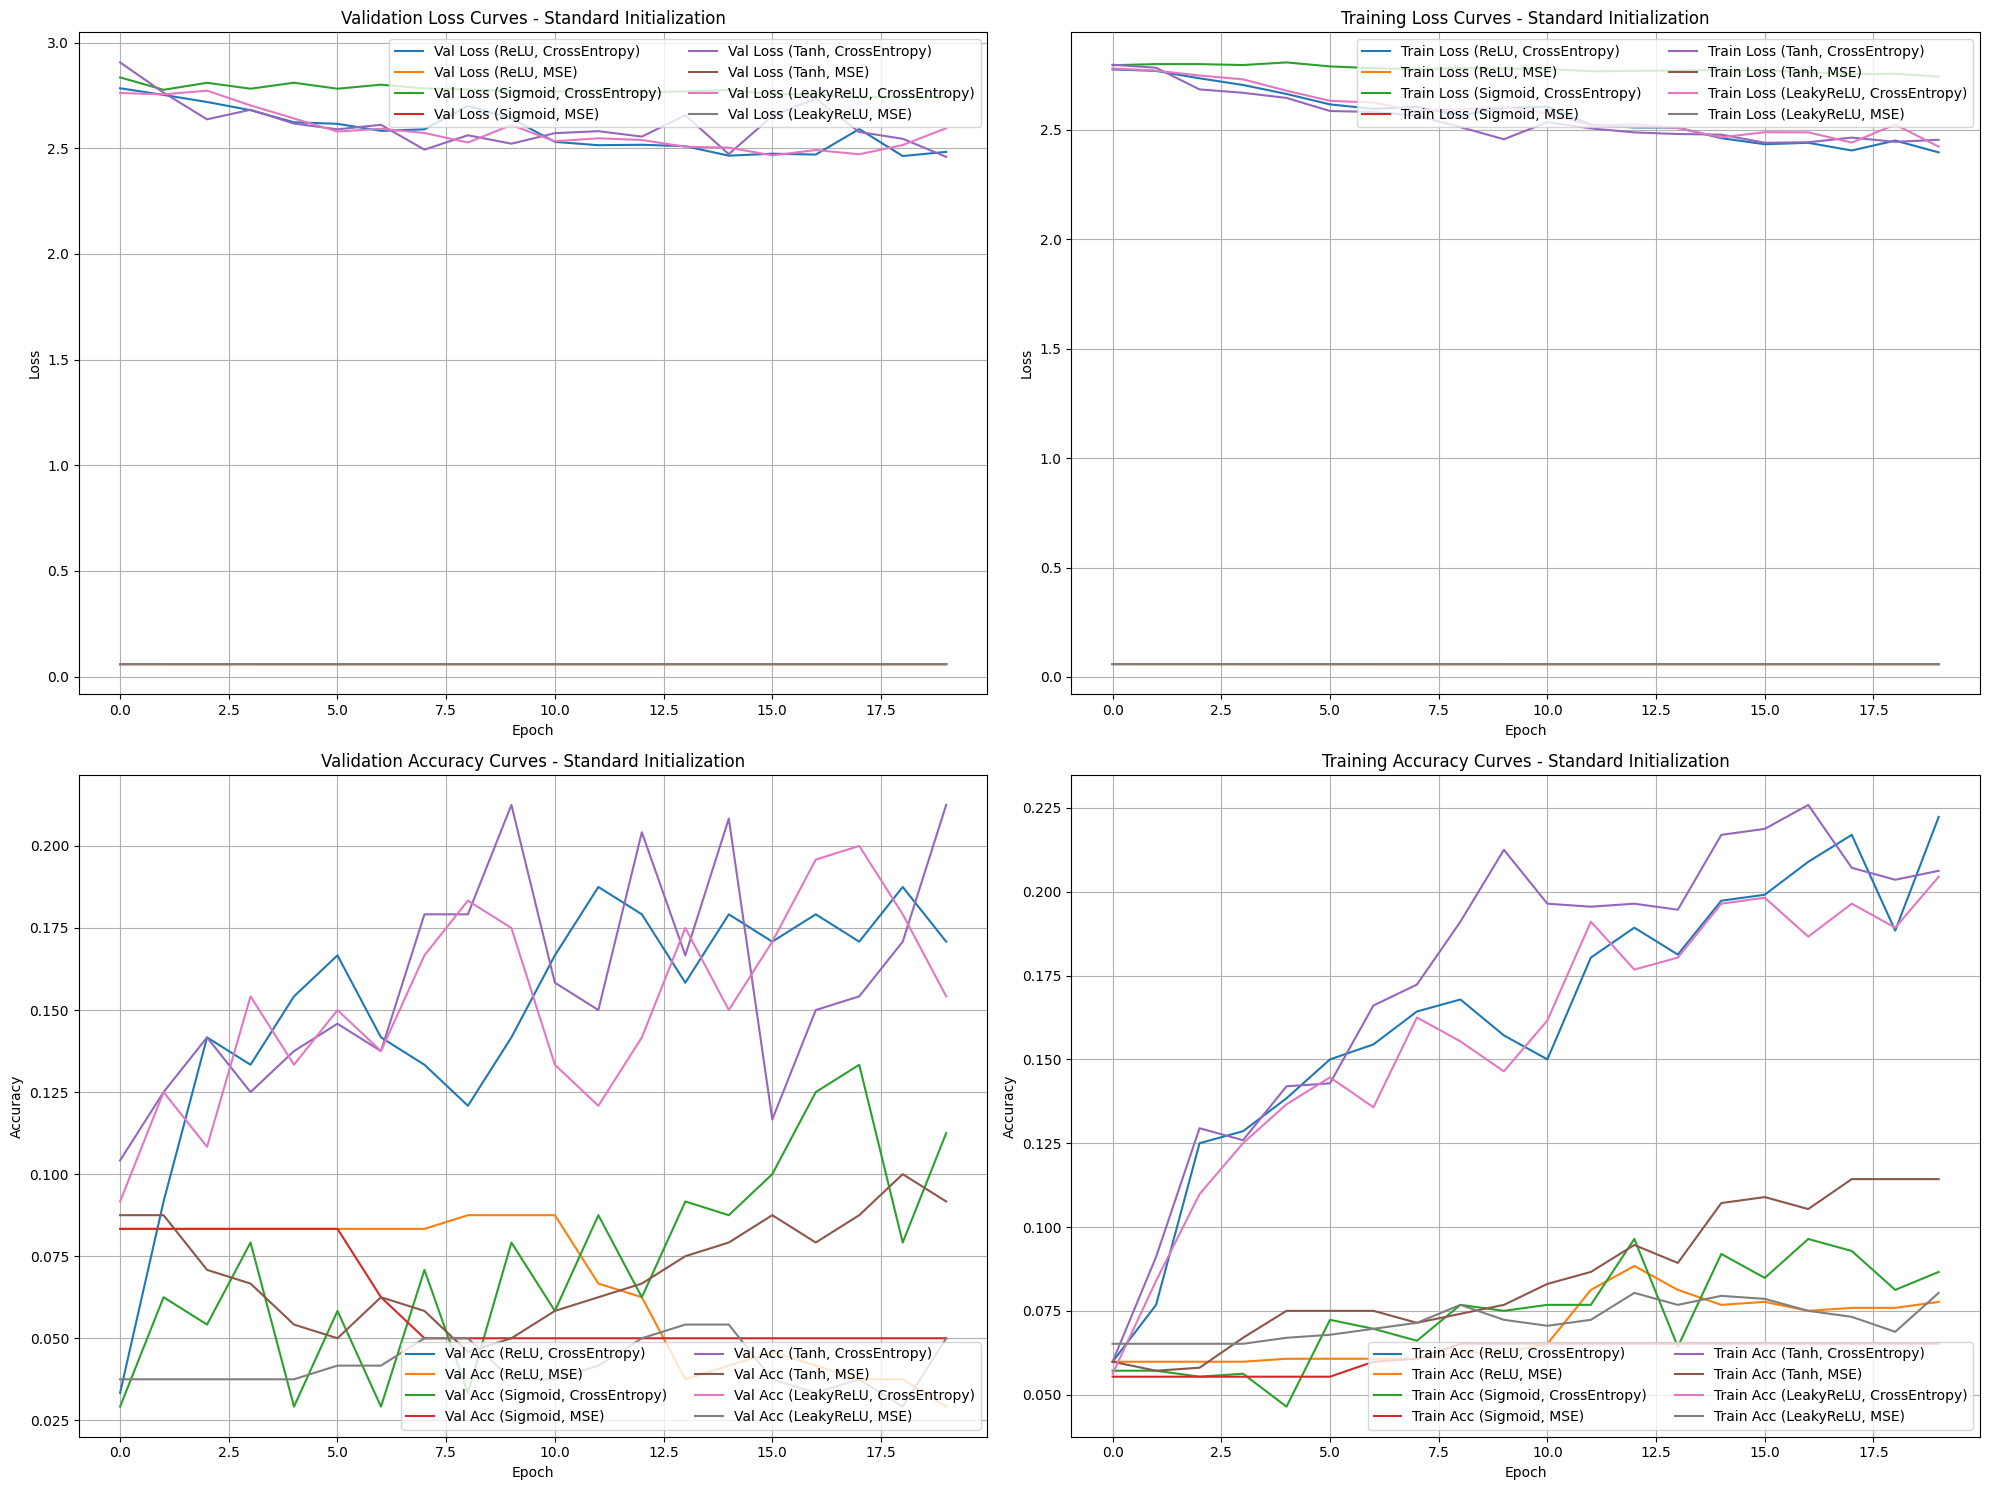

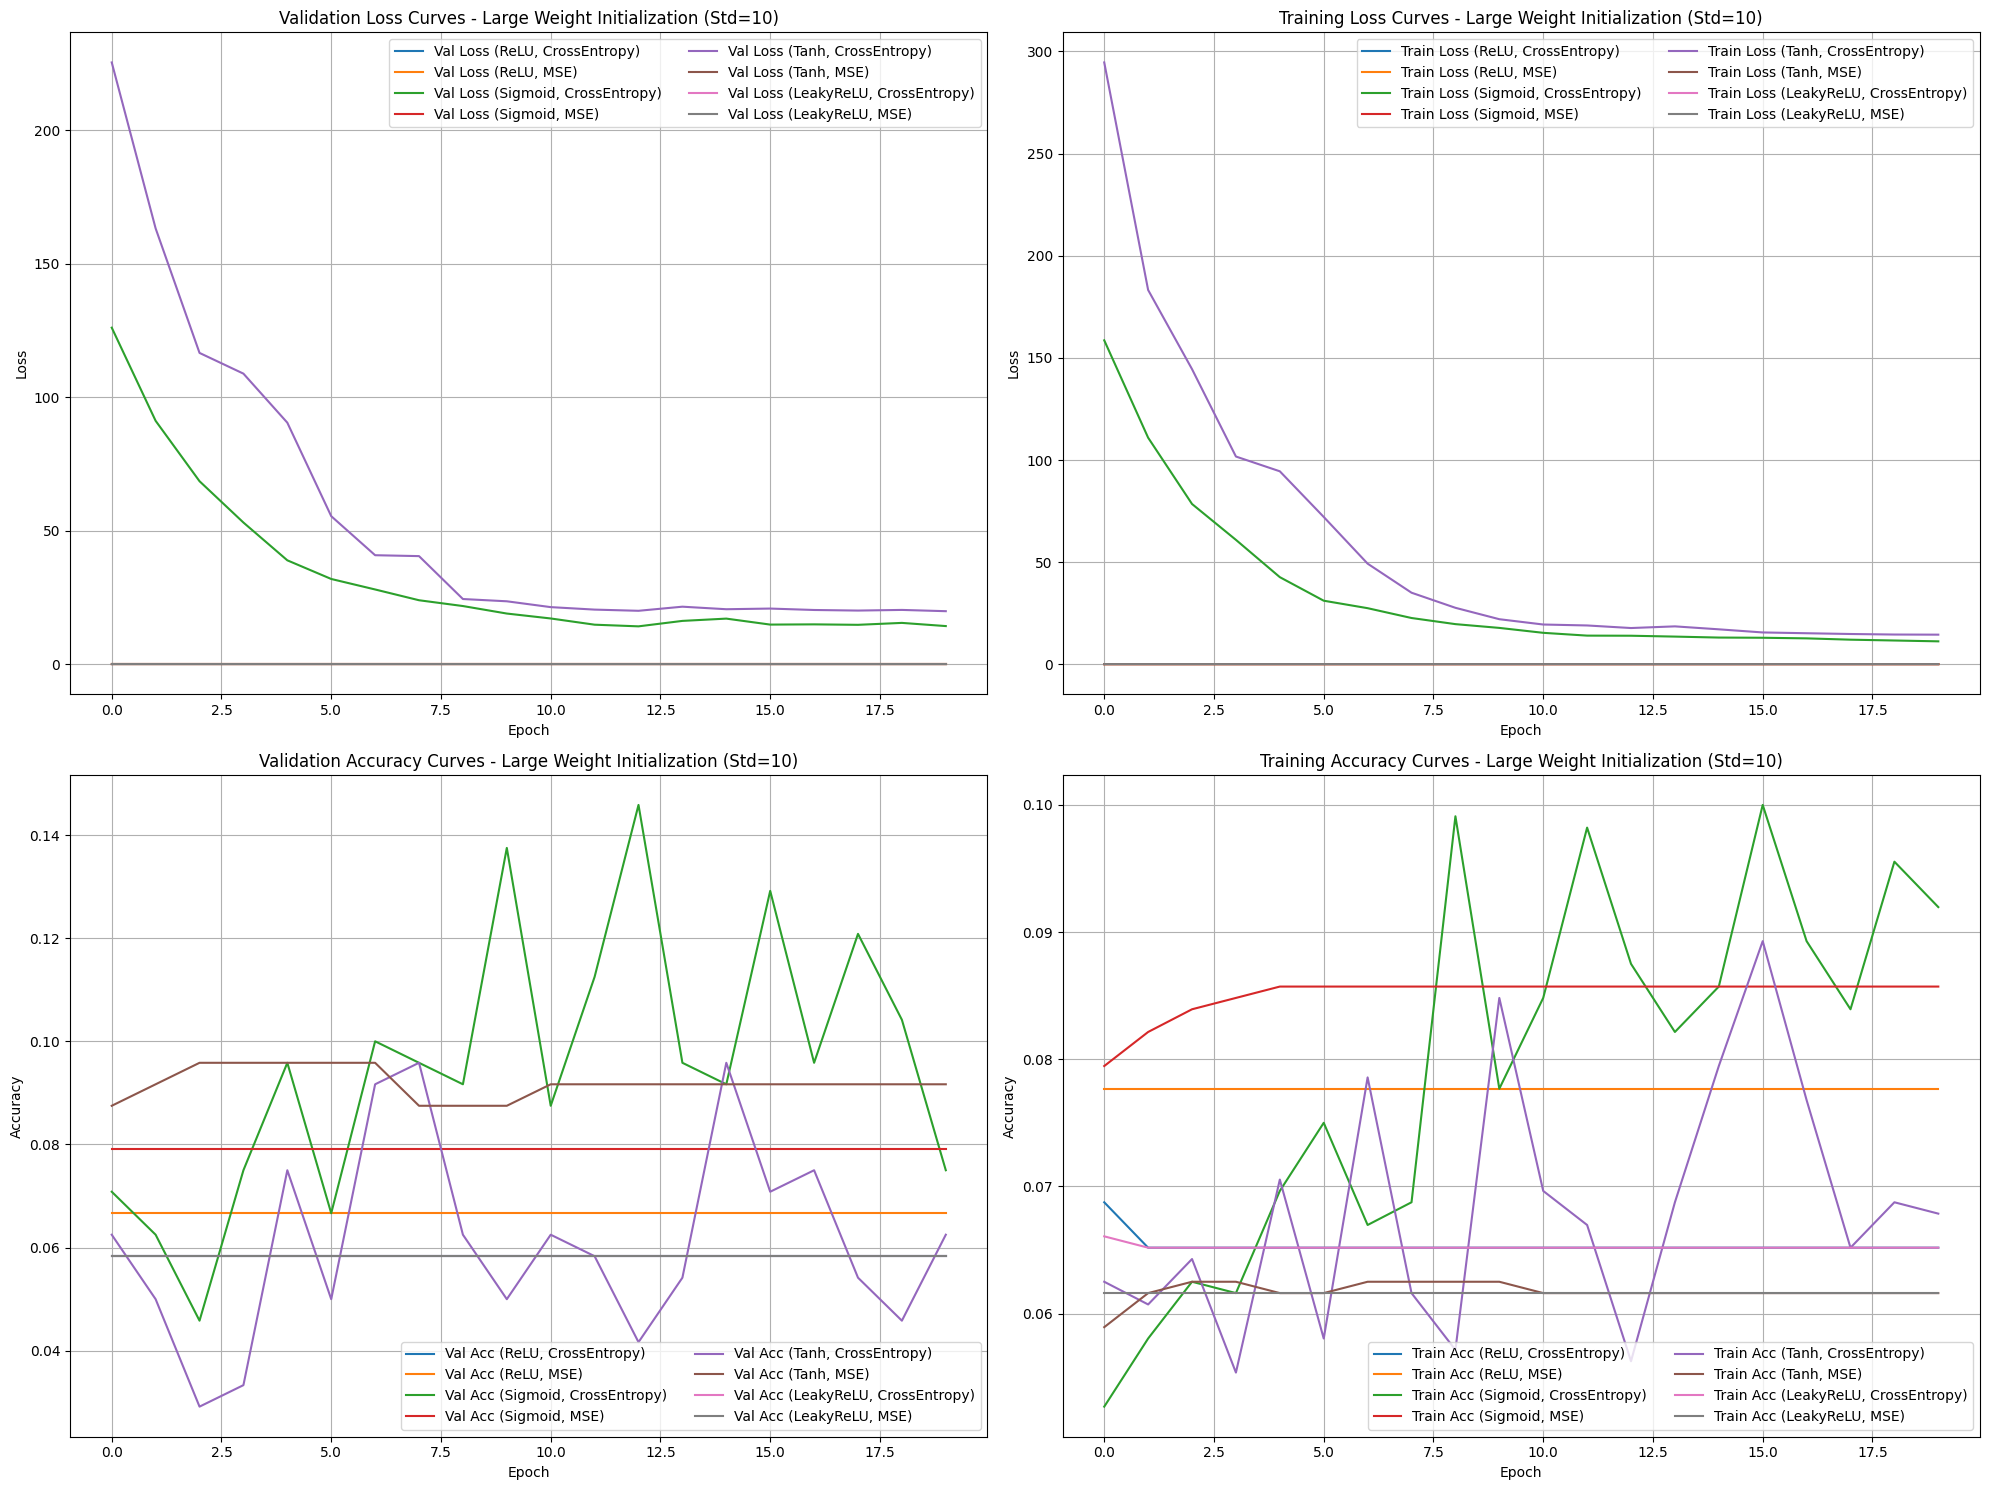


--- Task 3 Summary Table ---
Combination (Act, Loss, Init) Final Val Acc   Final Train Acc Test Acc        Time (s)  
--------------------------------------------------------------------------------
Tanh, CrossEntropy, Standa... 0.2125          0.2062          0.1917          167.49    
ReLU, CrossEntropy, Standa... 0.1708          0.2223          0.1833          168.68    
LeakyReLU, CrossEntropy, Standa... 0.1542          0.2045          0.1458          167.05    
Sigmoid, CrossEntropy, Standa... 0.1125          0.0866          0.1375          168.72    
Tanh, MSE, Standa... 0.0917          0.1143          0.1208          168.28    
Sigmoid, CrossEntropy, Large ... 0.0750          0.0920          0.1083          168.47    
LeakyReLU, MSE, Standa... 0.0500          0.0804          0.0958          167.85    
ReLU, MSE, Standa... 0.0292          0.0777          0.0875          168.54    
Tanh, CrossEntropy, Large ... 0.0625          0.0679          0.0792          168.25    
ReLU, MSE,

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# IMPORTANT: Assume the following are already defined from initial data loading:
# train_loader, val_loader, test_loader, input_size, output_size, class_names, device

print("\n\n--- Starting Task 3: Activation and Loss Functions Investigation ---")

class MLP_Task3(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes, activation_fn, use_softmax_output=False):
        super(MLP_Task3, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.activation1 = activation_fn
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.activation2 = activation_fn
        self.fc3 = nn.Linear(hidden_size2, num_classes)
        self.use_softmax_output = use_softmax_output
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = self.fc3(x)
        if self.use_softmax_output:
            x = self.softmax(x)
        return x

def to_one_hot(labels, num_classes):
    """Converts a tensor of class labels to one-hot encoded tensor."""
    return torch.eye(num_classes, device=labels.device)[labels]

def init_weights_large(m):
    """Initializes linear layer weights with large values (mean=0, std=10)."""
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=10)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0) # Biases often initialized to zero or small values

def train_and_evaluate_task3(model, criterion, optimizer, train_loader, val_loader, num_epochs, log_prefix="", is_mse_loss=False):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            if is_mse_loss:
                # For MSE, labels need to be one-hot and outputs should be probabilities (after softmax)
                labels_target = to_one_hot(labels, output_size).to(device)
                loss = criterion(outputs, labels_target)
            else:
                # For CrossEntropy, labels are integer class indices and outputs are raw logits
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            # For accuracy, always use argmax on raw logits (if available) or probabilities
            # If outputs came from softmax, argmax works directly.
            # If outputs are raw logits (CrossEntropy case), argmax works directly.
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                if is_mse_loss:
                    labels_target = to_one_hot(labels, output_size).to(device)
                    loss = criterion(outputs, labels_target)
                else:
                    loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_correct / val_total)

        print(f"{log_prefix}Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_losses[-1]:.4f} Train Acc: {train_accuracies[-1]:.4f} Val Loss: {val_losses[-1]:.4f} Val Acc: {val_accuracies[-1]:.4f}")
    return train_losses, val_losses, train_accuracies, val_accuracies

# --- Define experimental setups ---
num_epochs = 20
base_lr = 0.01
batch_size = 64
hidden_size1 = 512
hidden_size2 = 256
momentum = 0.9

activation_functions = {
    "ReLU": nn.ReLU(),
    "Sigmoid": nn.Sigmoid(),
    "Tanh": nn.Tanh(),
    "LeakyReLU": nn.LeakyReLU(negative_slope=0.01)
}

loss_functions = {
    "CrossEntropy": (nn.CrossEntropyLoss(), False), # (criterion, use_softmax_output_flag)
    "MSE": (nn.MSELoss(), True)
}

# Store results for plotting
results = {} # {(activation_name, loss_name, init_type): (train_losses, val_losses, train_accuracies, val_accuracies, training_time, test_accuracy)}

# --- Experiment 1: Standard Initialization (default PyTorch) ---
print("\n--- Experiment 1: Standard Initialization ---")

for act_name, activation_fn in activation_functions.items():
    for loss_name, (criterion_fn, use_softmax) in loss_functions.items():
        print(f"\n--- Training MLP with {act_name} Activation and {loss_name} Loss ---")

        model = MLP_Task3(input_size=input_size, hidden_size1=hidden_size1,
                          hidden_size2=hidden_size2, num_classes=output_size,
                          activation_fn=activation_fn, use_softmax_output=use_softmax).to(device)
        
        criterion = criterion_fn
        optimizer = optim.SGD(model.parameters(), lr=base_lr, momentum=momentum)

        start_time = time.time()
        train_l, val_l, train_a, val_a = \
            train_and_evaluate_task3(model, criterion, optimizer, train_loader, val_loader,
                                     num_epochs, f"MLP {act_name}-{loss_name}: ", is_mse_loss=use_softmax) # use_softmax here refers to if it's MSE loss
        
        training_time = time.time() - start_time

        # Calculate Test Accuracy
        model.eval()
        test_correct, test_total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
        test_accuracy = test_correct / test_total

        results[(act_name, loss_name, "Standard Init")] = (train_l, val_l, train_a, val_a, training_time, test_accuracy)
        print(f"Finished {act_name}-{loss_name} (Standard Init). Test Acc: {test_accuracy:.4f}, Time: {training_time:.2f}s")

# --- Experiment 2: Large Weight Initialization (mean=0, std=10) ---
print("\n--- Experiment 2: Large Weight Initialization ---")

for act_name, activation_fn in activation_functions.items():
    for loss_name, (criterion_fn, use_softmax) in loss_functions.items():
        print(f"\n--- Training MLP with {act_name} Activation and {loss_name} Loss (Large Init) ---")

        model = MLP_Task3(input_size=input_size, hidden_size1=hidden_size1,
                          hidden_size2=hidden_size2, num_classes=output_size,
                          activation_fn=activation_fn, use_softmax_output=use_softmax).to(device)
        
        # Apply large weight initialization
        model.apply(init_weights_large)
        
        criterion = criterion_fn
        optimizer = optim.SGD(model.parameters(), lr=base_lr, momentum=momentum)

        start_time = time.time()
        train_l, val_l, train_a, val_a = \
            train_and_evaluate_task3(model, criterion, optimizer, train_loader, val_loader,
                                     num_epochs, f"MLP {act_name}-{loss_name} (Large Init): ", is_mse_loss=use_softmax)
        
        training_time = time.time() - start_time

        # Calculate Test Accuracy
        model.eval()
        test_correct, test_total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
        test_accuracy = test_correct / test_total

        results[(act_name, loss_name, "Large Init")] = (train_l, val_l, train_a, val_a, training_time, test_accuracy)
        print(f"Finished {act_name}-{loss_name} (Large Init). Test Acc: {test_accuracy:.4f}, Time: {training_time:.2f}s")


# === Plotting and Final Summary for Task 3 ===

# Group results for plotting
plot_configs = {
    "Standard Init": [],
    "Large Init": []
}

for (act_name, loss_name, init_type), res in results.items():
    plot_configs[init_type].append(((act_name, loss_name), res))

# Plotting function
def plot_results(plot_data, title_suffix):
    plt.figure(figsize=(20, 15))
    
    # Loss Plots
    plt.subplot(2, 2, 1)
    for (act_name, loss_name), res in plot_data:
        val_l = res[1]
        plt.plot(val_l, label=f"Val Loss ({act_name}, {loss_name})")
    plt.title(f"Validation Loss Curves - {title_suffix}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='upper right', ncol=2)
    plt.grid(True)

    plt.subplot(2, 2, 2)
    for (act_name, loss_name), res in plot_data:
        train_l = res[0]
        plt.plot(train_l, label=f"Train Loss ({act_name}, {loss_name})")
    plt.title(f"Training Loss Curves - {title_suffix}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='upper right', ncol=2)
    plt.grid(True)

    # Accuracy Plots
    plt.subplot(2, 2, 3)
    for (act_name, loss_name), res in plot_data:
        val_a = res[3]
        plt.plot(val_a, label=f"Val Acc ({act_name}, {loss_name})")
    plt.title(f"Validation Accuracy Curves - {title_suffix}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='lower right', ncol=2)
    plt.grid(True)

    plt.subplot(2, 2, 4)
    for (act_name, loss_name), res in plot_data:
        train_a = res[2]
        plt.plot(train_a, label=f"Train Acc ({act_name}, {loss_name})")
    plt.title(f"Training Accuracy Curves - {title_suffix}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='lower right', ncol=2)
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot for Standard Initialization
plot_results(plot_configs["Standard Init"], "Standard Initialization")

# Plot for Large Initialization
plot_results(plot_configs["Large Init"], "Large Weight Initialization (Std=10)")


print("\n--- Task 3 Summary Table ---")
print("{:<20} {:<15} {:<15} {:<15} {:<10}".format("Combination (Act, Loss, Init)", "Final Val Acc", "Final Train Acc", "Test Acc", "Time (s)"))
print("-" * 80)
sorted_results = sorted(results.items(), key=lambda item: item[1][5], reverse=True) # Sort by Test Accuracy

for (act_name, loss_name, init_type), res in sorted_results:
    train_l, val_l, train_a, val_a, training_time, test_accuracy = res
    print("{:<20} {:<15.4f} {:<15.4f} {:<15.4f} {:<10.2f}".format(
        f"{act_name}, {loss_name}, {init_type[:6]}...",
        val_a[-1], train_a[-1], test_accuracy, training_time
    ))
print("-" * 80)
print("\nNote: 'MSE' loss combinations use a Softmax layer at the output.")
print("Leaky ReLU uses negative_slope=0.01.")

In [ ]:
# Example of a better structure for a full project
# (Initial data loading and splitting done only once)
# ... (your subset_indices, random_split code here) ...
# train_ds, val_ds, test_ds are now globally available

def get_data_loaders(train_dataset, val_dataset, test_dataset, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    return train_loader, val_loader, test_loader

# Then in Task 4:
# train_loader, val_loader, test_loader = get_data_loaders(train_ds, val_ds, test_ds, batch_size=64)
# ... (rest of Task 4 code) ...

# And in Task 5:
# for bs in batch_sizes:
#     train_loader, val_loader, _ = get_data_loaders(train_ds, val_ds, test_ds, batch_size=bs)
#     ... (rest of Task 5 code with current loaders) ...

# Task 4

Using device: cuda
Original dataset size: 47996
Subset dataset size: 1600 (should be 1600)

--- Running Baseline MLP (No Regularization) ---

--- Training Baseline MLP ---
Epoch [1/50] Baseline MLP - Train Loss: 2.9377 Acc: 0.0563 | Val Loss: 2.8300 Acc: 0.0500
Epoch [2/50] Baseline MLP - Train Loss: 2.7958 Acc: 0.0813 | Val Loss: 2.8105 Acc: 0.0750
Epoch [3/50] Baseline MLP - Train Loss: 2.7549 Acc: 0.1018 | Val Loss: 2.7671 Acc: 0.0750
Epoch [4/50] Baseline MLP - Train Loss: 2.7095 Acc: 0.1000 | Val Loss: 2.7906 Acc: 0.0708
Epoch [5/50] Baseline MLP - Train Loss: 2.6365 Acc: 0.1393 | Val Loss: 2.7216 Acc: 0.1083
Epoch [6/50] Baseline MLP - Train Loss: 2.6124 Acc: 0.1482 | Val Loss: 2.7453 Acc: 0.1125
Epoch [7/50] Baseline MLP - Train Loss: 2.6181 Acc: 0.1330 | Val Loss: 2.7127 Acc: 0.1125
Epoch [8/50] Baseline MLP - Train Loss: 2.5867 Acc: 0.1357 | Val Loss: 2.7416 Acc: 0.1042
Epoch [9/50] Baseline MLP - Train Loss: 2.5670 Acc: 0.1509 | Val Loss: 2.7057 Acc: 0.1000
Epoch [10/50] Base

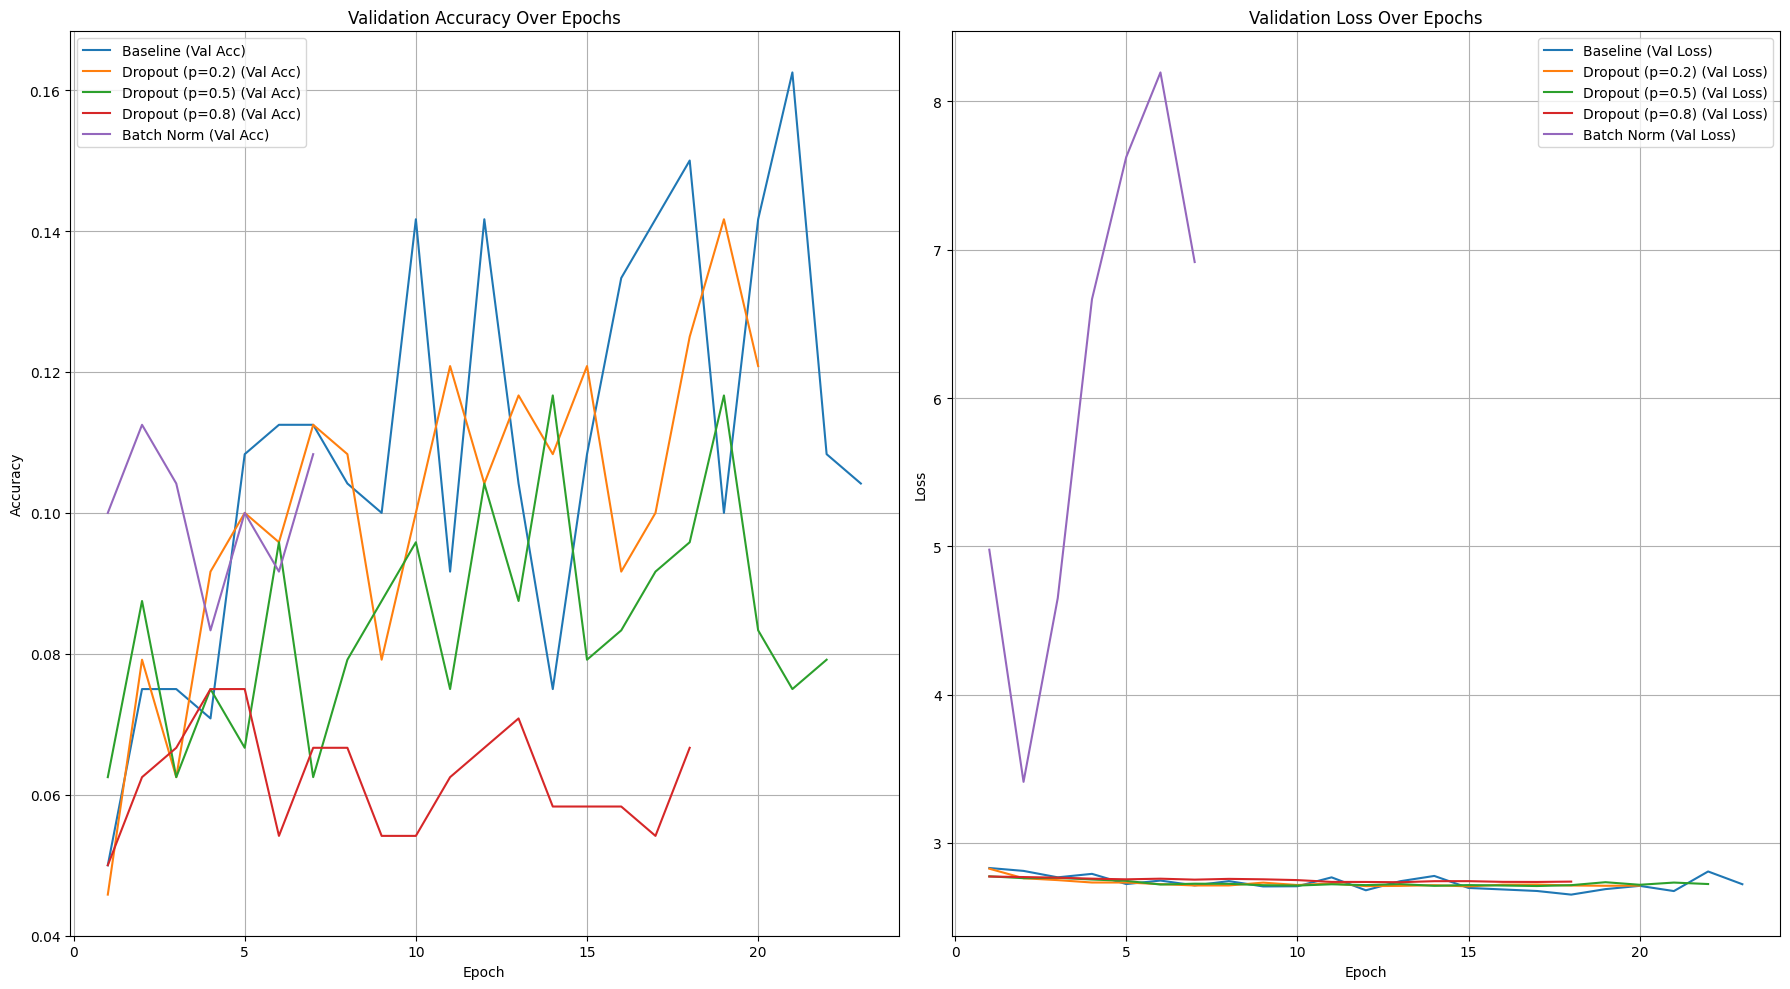


--- Task 4 Summary of Regularization and Early Stopping ---
Model Type           Test Accuracy   Stopping Epoch  Training Time (s) Final Val Acc  
--------------------------------------------------------------------------------
Baseline             0.2083          18              193.15          0.1500         
Dropout (p=0.2)      0.1875          15              168.33          0.1208         
Dropout (p=0.5)      0.1583          17              186.77          0.0917         
Dropout (p=0.8)      0.0917          13              151.29          0.0708         
Batch Norm           0.1708          2               58.72           0.1125         
--------------------------------------------------------------------------------


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from PIL import Image
from collections import defaultdict
import random
import matplotlib.pyplot as plt
import time
import numpy as np

# --- 0. Device Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 1. Data Loading and Preprocessing (Re-using from previous tasks) ---
# Convert tif to RGB and normalize to [0,1], flatten later
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensures 1 channel for grayscale images
    transforms.Resize((64, 64)),  # Resize for consistent input size
    transforms.ToTensor(),  # Converts to [0, 1]
    transforms.Lambda(lambda x: x.view(-1))  # Flatten to 1D vector
])

# Define the path to your dataset
# IMPORTANT: Adjust this path if your dataset is located elsewhere
data_path = "/kaggle/input/rvl-cdip-small/data" 

# Load the full dataset using ImageFolder
full_dataset = datasets.ImageFolder(root=data_path, transform=transform)
class_names = full_dataset.classes
output_size = len(class_names) # Should be 16 classes for RVL-CDIP

# --- Create a balanced subset with 100 images per class (from Task 1/2 setup) ---
# This ensures each class is equally represented in your smaller dataset for training
subset_indices = []
class_counts = defaultdict(int) # To keep track of images taken per class

for i, (path, class_idx) in enumerate(full_dataset.samples):
    if class_counts[class_idx] < 100: # Limit to 100 images per class
        subset_indices.append(i)
        class_counts[class_idx] += 1
    # Optimization: if all classes have 100 images, we can stop iterating
    if all(count >= 100 for count in class_counts.values()) and len(class_counts) == output_size:
        break

random.shuffle(subset_indices) # Shuffle the selected indices for randomness
dataset = Subset(full_dataset, subset_indices) # Create the new, smaller dataset

print(f"Original dataset size: {len(full_dataset)}")
print(f"Subset dataset size: {len(dataset)} (should be {output_size * 100})") # Expected: 16 * 100 = 1600

# Split the subset into training, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size # The remainder goes to test

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

# Using batch_size=64 as specified for Task 4
batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

input_size = 64 * 64 # Input dimension after resizing (64x64) and flattening

# --- 2. Model Definition: Flexible MLP for Regularization ---
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, num_classes, 
                 use_dropout=False, dropout_p=0.5, use_batchnorm=False):
        super(MLP, self).__init__()
        self.use_dropout = use_dropout
        self.use_batchnorm = use_batchnorm

        # First hidden layer: Linear -> [BatchNorm] -> ReLU -> [Dropout]
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        if self.use_batchnorm:
            self.bn1 = nn.BatchNorm1d(hidden_size_1) # Batch Norm before activation
        self.relu1 = nn.ReLU()
        if self.use_dropout:
            self.dropout1 = nn.Dropout(dropout_p) # Dropout after activation ("after hidden layer")

        # Second hidden layer: Linear -> [BatchNorm] -> ReLU -> [Dropout]
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        if self.use_batchnorm:
            self.bn2 = nn.BatchNorm1d(hidden_size_2) # Batch Norm before activation
        self.relu2 = nn.ReLU()
        if self.use_dropout:
            self.dropout2 = nn.Dropout(dropout_p) # Dropout after activation ("after hidden layer")

        # Output layer
        self.fc3 = nn.Linear(hidden_size_2, num_classes)

    def forward(self, x):
        # First layer operations
        out = self.fc1(x)
        if self.use_batchnorm:
            out = self.bn1(out) # Apply BatchNorm if enabled
        out = self.relu1(out) # Apply ReLU activation
        if self.use_dropout:
            out = self.dropout1(out) # Apply Dropout if enabled

        # Second layer operations
        out = self.fc2(out)
        if self.use_batchnorm:
            out = self.bn2(out) # Apply BatchNorm if enabled
        out = self.relu2(out) # Apply ReLU activation
        if self.use_dropout:
            out = self.dropout2(out) # Apply Dropout if enabled

        # Output layer
        out = self.fc3(out)
        return out

# --- 3. Training Function with Early Stopping ---
def train_and_evaluate_with_early_stopping(model, train_loader, val_loader, 
                                           num_epochs, learning_rate, patience, 
                                           model_name="Model"):
    
    criterion = nn.CrossEntropyLoss() # Standard loss for multi-class classification
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Adam optimizer as specified

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    best_val_loss = float('inf') # Initialize with a very high loss
    epochs_no_improve = 0 # Counter for epochs without improvement
    best_epoch = 0 # Stores the epoch at which the best model was saved
    best_model_state = None # To save the state dictionary of the best model
    
    start_time = time.time() # Start time for training duration calculation

    print(f"\n--- Training {model_name} ---")
    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train() # Set model to training mode (important for Dropout and BatchNorm)
        running_train_loss = 0.0
        correct_train, total_train = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device) # Move data to device

            optimizer.zero_grad() # Clear gradients
            outputs = model(images) # Forward pass
            loss = criterion(outputs, labels) # Calculate loss
            loss.backward() # Backward pass (compute gradients)
            optimizer.step() # Update weights

            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1) # Get the class with the highest score
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_loss = running_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train

        # --- Validation Phase ---
        model.eval() # Set model to evaluation mode (important for Dropout and BatchNorm)
        running_val_loss = 0.0
        correct_val, total_val = 0, 0
        with torch.no_grad(): # Disable gradient calculation for validation
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}] {model_name} - Train Loss: {train_loss:.4f} Acc: {train_accuracy:.4f} | Val Loss: {val_loss:.4f} Acc: {val_accuracy:.4f}")

        # --- Early Stopping Logic ---
        if val_loss < best_val_loss: # If validation loss has improved
            best_val_loss = val_loss
            epochs_no_improve = 0 # Reset counter
            best_epoch = epoch + 1 # Record current epoch
            best_model_state = model.state_dict() # Save the current model state
        else:
            epochs_no_improve += 1 # Increment counter if no improvement
            if epochs_no_improve >= patience: # If patience limit reached
                print(f"Early stopping triggered after {best_epoch} epochs (patience={patience}).")
                break # Stop training loop
    
    end_time = time.time()
    training_time = end_time - start_time

    # Load the best model state before returning, so the returned model is the best one
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    return train_losses, val_losses, train_accuracies, val_accuracies, training_time, best_epoch

# --- 4. Test Evaluation Function ---
def evaluate_model_on_test_set(model, test_loader):
    model.eval() # Set model to evaluation mode
    correct_test, total_test = 0, 0
    with torch.no_grad(): # Disable gradient calculation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1) # Get predicted class
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    test_accuracy = correct_test / total_test
    return test_accuracy

# --- 5. Hyperparameters for Task 4 experiments ---
hidden_size_1 = 512 # Number of neurons in the first hidden layer
hidden_size_2 = 256 # Number of neurons in the second hidden layer
num_epochs = 50 # Maximum number of epochs to train for
learning_rate = 0.001 # Learning rate for the Adam optimizer
early_stopping_patience = 5 # Number of epochs to wait for improvement before stopping

# Dictionary to store results for all scenarios
all_results = {}

# --- Scenario 1: Baseline MLP (No Regularization) ---
print("\n--- Running Baseline MLP (No Regularization) ---")
# Create a model without dropout or batch normalization
baseline_model = MLP(input_size, hidden_size_1, hidden_size_2, output_size).to(device)
(bl_train_l, bl_val_l, bl_train_a, bl_val_a, bl_time, bl_epochs) = \
    train_and_evaluate_with_early_stopping(baseline_model, train_loader, val_loader, 
                                           num_epochs, learning_rate, early_stopping_patience,
                                           model_name="Baseline MLP")
bl_test_acc = evaluate_model_on_test_set(baseline_model, test_loader)
all_results["Baseline"] = {
    'train_loss': bl_train_l, 'val_loss': bl_val_l,
    'train_acc': bl_train_a, 'val_acc': bl_val_a,
    'time': bl_time, 'epochs': bl_epochs, 'test_acc': bl_test_acc
}

# --- Scenario 2: MLP with Dropout (various probabilities) ---
dropout_ps = [0.2, 0.5, 0.8] # Dropout probabilities to test
for p in dropout_ps:
    print(f"\n--- Running MLP with Dropout (p={p}) ---")
    # Create a model with dropout enabled and specified probability
    dropout_model = MLP(input_size, hidden_size_1, hidden_size_2, output_size, 
                        use_dropout=True, dropout_p=p).to(device)
    (dp_train_l, dp_val_l, dp_train_a, dp_val_a, dp_time, dp_epochs) = \
        train_and_evaluate_with_early_stopping(dropout_model, train_loader, val_loader, 
                                               num_epochs, learning_rate, early_stopping_patience,
                                               model_name=f"Dropout MLP (p={p})")
    dp_test_acc = evaluate_model_on_test_set(dropout_model, test_loader)
    all_results[f"Dropout (p={p})"] = {
        'train_loss': dp_train_l, 'val_loss': dp_val_l,
        'train_acc': dp_train_a, 'val_acc': dp_val_a,
        'time': dp_time, 'epochs': dp_epochs, 'test_acc': dp_test_acc
    }

# --- Scenario 3: MLP with Batch Normalization ---
print("\n--- Running MLP with Batch Normalization ---")
# Create a model with batch normalization enabled
bn_model = MLP(input_size, hidden_size_1, hidden_size_2, output_size, 
               use_batchnorm=True).to(device)
(bn_train_l, bn_val_l, bn_train_a, bn_val_a, bn_time, bn_epochs) = \
    train_and_evaluate_with_early_stopping(bn_model, train_loader, val_loader, 
                                           num_epochs, learning_rate, early_stopping_patience,
                                           model_name="Batch Norm MLP")
bn_test_acc = evaluate_model_on_test_set(bn_model, test_loader)
all_results["Batch Norm"] = {
    'train_loss': bn_train_l, 'val_loss': bn_val_l,
    'train_acc': bn_train_a, 'val_acc': bn_val_a,
    'time': bn_time, 'epochs': bn_epochs, 'test_acc': bn_test_acc
}

# --- 6. Plotting Results ---
plt.figure(figsize=(18, 10))

# Plot Validation Accuracy for all models
plt.subplot(1, 2, 1)
for name, res in all_results.items():
    # Plot only up to the stopping epoch
    plt.plot(range(1, len(res['val_acc']) + 1), res['val_acc'], label=f"{name} (Val Acc)")
plt.title("Validation Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Plot Validation Loss for all models
plt.subplot(1, 2, 2)
for name, res in all_results.items():
    # Plot only up to the stopping epoch
    plt.plot(range(1, len(res['val_loss']) + 1), res['val_loss'], label=f"{name} (Val Loss)")
plt.title("Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout() # Adjust layout to prevent overlapping
plt.show()

# --- 7. Summary Table ---
print("\n--- Task 4 Summary of Regularization and Early Stopping ---")
# Print header for the summary table
print("{:<20} {:<15} {:<15} {:<15} {:<15}".format("Model Type", "Test Accuracy", "Stopping Epoch", "Training Time (s)", "Final Val Acc"))
print("-" * 80) # Separator line

# Iterate through collected results and print them in a formatted table
for name, res in all_results.items():
    print("{:<20} {:<15.4f} {:<15} {:<15.2f} {:<15.4f}".format(
        name, res['test_acc'], res['epochs'], res['time'], res['val_acc'][res['epochs']-1] # Note: res['epochs']-1 for the last epoch's recorded val_acc
    ))
print("-" * 80)

# Task 5

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from PIL import Image
from collections import defaultdict
import random
import matplotlib.pyplot as plt
import time
import itertools # Essential for generating combinations for grid search
import numpy as np

# --- 0. Device Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 1. Data Loading and Preprocessing (Re-using from previous tasks) ---
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((64, 64)),  # Resize images to 64x64 pixels
    transforms.ToTensor(),  # Convert PIL Image or numpy.ndarray to tensor, scales to [0, 1]
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the 64x64 image into a 1D vector (4096 features)
])

# Define the path to your dataset. IMPORTANT: Adjust this path if your dataset is located elsewhere.
data_path = "/kaggle/input/rvl-cdip-small/data" 

# Load the full dataset using ImageFolder. This allows torchvision to automatically find classes.
full_dataset = datasets.ImageFolder(root=data_path, transform=transform)
class_names = full_dataset.classes
output_size = len(class_names) # Number of output classes (e.g., 16 for RVL-CDIP)

# --- Create a balanced subset with 100 images per class (as established in earlier tasks) ---
# This helps in faster experimentation and ensures class balance.
subset_indices = []
class_counts = defaultdict(int) # Dictionary to track how many images have been selected per class

# Iterate through the dataset samples to pick 100 images for each class
for i, (path, class_idx) in enumerate(full_dataset.samples):
    if class_counts[class_idx] < 100: # If we haven't reached 100 images for this class yet
        subset_indices.append(i) # Add the index to our list
        class_counts[class_idx] += 1 # Increment the count for this class
    # Optimization: if all classes have 100 images, we can stop the loop early
    if all(count >= 100 for count in class_counts.values()) and len(class_counts) == output_size:
        break

random.shuffle(subset_indices) # Shuffle the selected indices for randomness
dataset = Subset(full_dataset, subset_indices) # Create the new, smaller dataset using the selected indices

print(f"Original dataset size: {len(full_dataset)}")
print(f"Subset dataset size: {len(dataset)} (should be {output_size * 100})") # Expected: 16 classes * 100 images/class = 1600 images

# Split the balanced subset into training, validation, and test sets.
# Note: DataLoaders will be created inside the grid search loop for each batch_size.
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size # The remainder goes to the test set

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

input_size = 64 * 64 # Input dimension for the MLP after flattening the 64x64 image

# --- 2. Model Definition: Flexible MLP (from Task 4, tailored for Task 5) ---
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, num_classes, 
                 use_dropout=False, dropout_p=0.5, use_batchnorm=False): # Batch Norm is kept in class but not used in Task 5 explicitly
        super(MLP, self).__init__()
        self.use_dropout = use_dropout
        self.use_batchnorm = use_batchnorm # Will be False for this task

        # First hidden layer: Linear -> [BatchNorm (if enabled)] -> ReLU -> [Dropout (if enabled)]
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        if self.use_batchnorm:
            self.bn1 = nn.BatchNorm1d(hidden_size_1)
        self.relu1 = nn.ReLU() # ReLU activation as specified
        if self.use_dropout:
            self.dropout1 = nn.Dropout(dropout_p) # Dropout after the hidden layer (after ReLU)

        # Second hidden layer: Linear -> [BatchNorm (if enabled)] -> ReLU -> [Dropout (if enabled)]
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        if self.use_batchnorm:
            self.bn2 = nn.BatchNorm1d(hidden_size_2)
        self.relu2 = nn.ReLU() # ReLU activation as specified
        if self.use_dropout:
            self.dropout2 = nn.Dropout(dropout_p) # Dropout after the hidden layer (after ReLU)

        # Output layer
        self.fc3 = nn.Linear(hidden_size_2, num_classes)

    def forward(self, x):
        # Operations for the first hidden layer
        out = self.fc1(x)
        if self.use_batchnorm:
            out = self.bn1(out)
        out = self.relu1(out)
        if self.use_dropout:
            out = self.dropout1(out)

        # Operations for the second hidden layer
        out = self.fc2(out)
        if self.use_batchnorm:
            out = self.bn2(out)
        out = self.relu2(out)
        if self.use_dropout:
            out = self.dropout2(out)

        # Output layer
        out = self.fc3(out)
        return out

# --- 3. Training Function for Grid Search (fixed epochs, no early stopping) ---
def train_grid_search_config(model, train_loader, val_loader, num_epochs, learning_rate):
    """
    Trains the model for a fixed number of epochs and returns validation accuracies and training time.
    No early stopping is applied here, as grid search typically requires a fixed training duration
    for fair comparison.
    """
    criterion = nn.CrossEntropyLoss() # Standard loss for multi-class classification
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Adam optimizer

    val_accuracies = [] # To store validation accuracy at the end of each epoch
    
    start_time = time.time() # Record start time for training duration

    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train() # Set model to training mode (enables Dropout)
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device) # Move data to the selected device

            optimizer.zero_grad() # Clear previous gradients
            outputs = model(images) # Forward pass
            loss = criterion(outputs, labels) # Calculate loss
            loss.backward() # Backward pass: compute gradient of the loss
            optimizer.step() # Update model parameters

        # --- Validation Phase ---
        model.eval() # Set model to evaluation mode (disables Dropout)
        correct_val, total_val = 0, 0
        with torch.no_grad(): # Disable gradient calculation for efficiency and to prevent learning
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1) # Get the index of the max log-probability
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        val_accuracy = correct_val / total_val # Calculate validation accuracy for the current epoch
        val_accuracies.append(val_accuracy) # Store it
        
        # Optional: Print progress for monitoring long runs, can be commented out for cleaner output
        # print(f"  Epoch [{epoch+1}/{num_epochs}] Val Acc: {val_accuracy:.4f}")
    
    end_time = time.time()
    training_time = end_time - start_time # Calculate total training time for this configuration
    
    return val_accuracies, training_time

# --- 4. Test Evaluation Function (from Task 4, reusable) ---
def evaluate_model_on_test_set(model, test_loader):
    """Evaluates the model's performance on the test dataset."""
    model.eval() # Set model to evaluation mode
    correct_test, total_test = 0, 0
    with torch.no_grad(): # No need to compute gradients during testing
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1) # Get the predicted class
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    test_accuracy = correct_test / total_test # Calculate overall test accuracy
    return test_accuracy

# --- 5. Hyperparameter Grid for Task 5 ---
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [32, 64, 128]
hidden_layer_configs = [(512, 256), (256, 256), (256, 128), (1024, 512)]

num_epochs_grid_search = 20 # Train each configuration for exactly 20 epochs
fixed_dropout_p = 0.5 # Dropout probability fixed at 0.5 as per task requirement

# List to store results for each combination in the grid search
grid_search_results = []
best_val_accuracy = -1.0 # Initialize with a low value to find the maximum
best_config_details = None # Stores the hyperparameters of the best configuration
best_model_state_for_test = None # Stores the state_dict of the model that achieved the best validation accuracy

print("\n--- Starting Grid Search for Hyperparameter Tuning (Task 5) ---")

# Use itertools.product to generate all combinations of hyperparameters
for lr, bs, (h1, h2) in itertools.product(learning_rates, batch_sizes, hidden_layer_configs):
    print(f"\n--- Training Configuration: LR={lr}, Batch Size={bs}, Hidden Sizes=({h1}, {h2}) ---")
    
    # Re-create DataLoader for current batch size. This is crucial as batch_size changes.
    train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=bs)

    # Initialize a new model for the current configuration
    # Note: use_batchnorm is False as it's not specified for this task,
    # and dropout_p is fixed at 0.5.
    model = MLP(input_size, h1, h2, output_size, 
                use_dropout=True, dropout_p=fixed_dropout_p, use_batchnorm=False).to(device)

    # Train the model with the current configuration
    val_accuracies, training_time = train_grid_search_config(
        model, train_loader, val_loader, num_epochs_grid_search, lr
    )
    
    final_val_accuracy = val_accuracies[-1] # Get the validation accuracy from the last (20th) epoch

    # Store all relevant information for this configuration
    config_info = {
        'learning_rate': lr,
        'batch_size': bs,
        'hidden_sizes': (h1, h2),
        'val_accuracies': val_accuracies, # Full list of accuracies over epochs
        'final_val_accuracy': final_val_accuracy,
        'training_time': training_time,
        'model_state_dict': model.state_dict() # Save the trained model's weights
    }
    grid_search_results.append(config_info)

    # Check if this configuration is the best so far based on final validation accuracy
    if final_val_accuracy > best_val_accuracy:
        best_val_accuracy = final_val_accuracy
        best_config_details = config_info # Store the details of this best configuration
        best_model_state_for_test = model.state_dict() # Store its state_dict for test evaluation

# --- 6. Analysis and Visualization ---

print("\n--- Grid Search Complete ---")
print("\n--- Summary of All Configurations ---")
# Print a formatted header for the summary table
print("{:<10} {:<15} {:<20} {:<20} {:<15}".format("LR", "Batch Size", "Hidden Sizes", "Final Val Acc", "Train Time (s)"))
print("-" * 90) # Separator line

# Iterate through the collected results and print them
for result in grid_search_results:
    print("{:<10} {:<15} {:<20} {:<20.4f} {:<15.2f}".format(
        result['learning_rate'],
        result['batch_size'],
        str(result['hidden_sizes']), # Convert tuple to string for printing
        result['final_val_accuracy'],
        result['training_time']
    ))
print("-" * 90)

# Plotting Validation Accuracy for each configuration over epochs
plt.figure(figsize=(15, 9)) # Adjust figure size for better readability
for i, result in enumerate(grid_search_results):
    # Create a descriptive label for each plot line
    label = (f"LR={result['learning_rate']}, BS={result['batch_size']}, "
             f"H={result['hidden_sizes']}")
    plt.plot(range(1, num_epochs_grid_search + 1), result['val_accuracies'], label=label)

plt.title("Validation Accuracy for Each Hyperparameter Configuration (Task 5)")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
# Place legend outside the plot area for better visibility, especially with many lines
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.) 
plt.grid(True)
plt.tight_layout() # Adjust layout to prevent labels/elements from overlapping
plt.show()

# --- 7. Validate Best Configuration on Test Set ---
if best_config_details:
    print(f"\n--- Best Configuration Found ---")
    print(f"Learning Rate: {best_config_details['learning_rate']}")
    print(f"Batch Size: {best_config_details['batch_size']}")
    print(f"Hidden Sizes: {best_config_details['hidden_sizes']}")
    print(f"Final Validation Accuracy: {best_config_details['final_val_accuracy']:.4f}")
    print(f"Training Time: {best_config_details['training_time']:.2f} seconds")

    # Create a DataLoader for the test set using the batch size of the best configuration
    best_test_loader = DataLoader(test_ds, batch_size=best_config_details['batch_size'])

    # Re-instantiate the model with the best parameters and load its saved state_dict.
    # This ensures we are evaluating the exact model that achieved the highest validation accuracy.
    best_h1, best_h2 = best_config_details['hidden_sizes']
    best_model_for_evaluation = MLP(input_size, best_h1, best_h2, output_size, 
                                    use_dropout=True, dropout_p=fixed_dropout_p, use_batchnorm=False).to(device)
    best_model_for_evaluation.load_state_dict(best_model_state_for_test) # Load the weights

    # Evaluate the best model on the test set
    test_accuracy = evaluate_model_on_test_set(best_model_for_evaluation, best_test_loader)
    print(f"\nTest Accuracy for Best Configuration: {test_accuracy:.4f}")
else:
    print("No configurations were trained. Please check the grid search parameters and data loading.")

# --- 8. Analysis of Training Time vs. Performance Trade-offs ---
print("\n--- Analysis Guidance: Training Time vs. Performance Trade-offs ---")
print("Refer to the 'Summary of All Configurations' table and the 'Validation Accuracy' plot for your analysis.")
print("\nConsider the following questions for your report:")
print("1. **Learning Rate Impact:** How did different learning rates (0.001, 0.01, 0.1) affect:")
print("   - The speed of convergence (how quickly validation accuracy increased).")
print("   - The stability of training (e.g., did 0.1 cause erratic behavior or divergence?).")
print("   - The final validation accuracy achieved after 20 epochs.")
print("2. **Batch Size Impact:** Analyze the effect of batch sizes (32, 64, 128) on:")
print("   - Total training time for 20 epochs (larger batch sizes often lead to faster training *per epoch* but might require more epochs to converge or might get stuck in local minima).")
print("   - The smoothness of the validation accuracy curve.")
print("   - The final validation accuracy.")
print("3. **Hidden Layer Size Impact:** Compare the performance and training time of different hidden layer configurations:")
print("   - Did larger models (e.g., (1024, 512)) consistently outperform smaller ones (e.g., (256, 128))?")
print("   - Was the increase in performance (if any) proportional to the increase in training time for larger models?")
print("   - Did any of the smaller models offer a surprisingly good balance of accuracy and speed?")
print("4. **Trade-offs and Optimal Configuration:**")
print("   - Identify if there are configurations that offer a good balance between training time and performance (e.g., achieving near-best accuracy with significantly less training time).")
print("   - Discuss your findings on the 'best' hyperparameters for this specific task and model. Justify your choice based on both performance (validation/test accuracy) and computational cost (training time).")
print("\nThis detailed analysis will help you understand the interplay of different hyperparameters.")

Using device: cuda
Original dataset size: 47996
Subset dataset size: 1600 (should be 1600)

--- Starting Grid Search for Hyperparameter Tuning (Task 5) ---

--- Training Configuration: LR=0.001, Batch Size=32, Hidden Sizes=(512, 256) ---

--- Training Configuration: LR=0.001, Batch Size=32, Hidden Sizes=(256, 256) ---

--- Training Configuration: LR=0.001, Batch Size=32, Hidden Sizes=(256, 128) ---

--- Training Configuration: LR=0.001, Batch Size=32, Hidden Sizes=(1024, 512) ---

--- Training Configuration: LR=0.001, Batch Size=64, Hidden Sizes=(512, 256) ---

--- Training Configuration: LR=0.001, Batch Size=64, Hidden Sizes=(256, 256) ---


# Task 6

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from PIL import Image
from collections import defaultdict
import random
import matplotlib.pyplot as plt
import time
import numpy as np

# --- 0. Device Configuration ---
# Automatically selects GPU if available, otherwise uses CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 1. Data Loading and Preprocessing ---
# Define transformations: grayscale, resize, convert to tensor, and flatten
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((64, 64)),                  # Resize images to 64x64 pixels
    transforms.ToTensor(),                        # Convert PIL Image to PyTorch Tensor, scales to [0, 1]
    transforms.Lambda(lambda x: x.view(-1))       # Flatten the 64x64 image into a 1D vector (4096 features)
])

# Define the path to your dataset. Adjust this path if your dataset is located elsewhere.
# Assuming 'rvl-cdip-small' is a dataset folder containing 'data'
data_path = "/kaggle/input/rvl-cdip-small/data"

# Load the full dataset using ImageFolder, which automatically infers classes from subdirectories
full_dataset = datasets.ImageFolder(root=data_path, transform=transform)
class_names = full_dataset.classes
output_size = len(class_names) # Number of output classes (e.g., 16 for RVL-CDIP)

# --- Create a balanced subset with 100 images per class ---
# This ensures faster experimentation and maintains class balance across splits.
subset_indices = []
class_counts = defaultdict(int) # Dictionary to track selected images per class

# Iterate through dataset samples to select 100 images for each class
for i, (path, class_idx) in enumerate(full_dataset.samples):
    if class_counts[class_idx] < 100: # If limit not reached for this class
        subset_indices.append(i)      # Add index to subset
        class_counts[class_idx] += 1  # Increment count
    # Stop early if all classes have 100 images
    if all(count >= 100 for count in class_counts.values()) and len(class_counts) == output_size:
        break

random.shuffle(subset_indices) # Shuffle selected indices for randomness
dataset = Subset(full_dataset, subset_indices) # Create the balanced subset

print(f"Original dataset size: {len(full_dataset)}")
print(f"Subset dataset size: {len(dataset)} (expected: {output_size * 100})") # Expected: 16 classes * 100 images/class = 1600 images

# Split the balanced subset into training, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size # Remainder goes to test set

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

# Common DataLoader for experiments, with a fixed batch size as per task
batch_size_fixed = 64
train_loader = DataLoader(train_ds, batch_size=batch_size_fixed, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size_fixed)
test_loader = DataLoader(test_ds, batch_size=batch_size_fixed)

input_size = 64 * 64 # Input dimension after flattening 64x64 image

# --- 2. Model Definition: Deep MLP for Gradient Issues Diagnosis ---
class DeepMLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_hidden_layers, activation_fn, use_xavier_init=False):
        super(DeepMLP, self).__init__()
        self.layers = nn.ModuleList()
        self.activation = activation_fn() # Instantiate the activation function (e.g., nn.Sigmoid(), nn.ReLU())

        # Define all linear layers.
        # It's an input layer, (num_hidden_layers - 1) intermediate hidden layers, and an output layer.
        # Example: 10 hidden layers means 1 (input-to-H1) + 9 (H-to-H) + 1 (H-to-Output) = 11 Linear layers.
        self.layers.append(nn.Linear(input_size, hidden_size)) # First layer: input to first hidden
        for _ in range(num_hidden_layers - 1): # Intermediate hidden layers
            self.layers.append(nn.Linear(hidden_size, hidden_size))
        self.layers.append(nn.Linear(hidden_size, num_classes)) # Last layer: final hidden to output

        # Apply custom initialization if requested
        if use_xavier_init:
            self._initialize_weights()

    def _initialize_weights(self):
        """Applies Xavier Uniform initialization to Linear layer weights and zeros to biases."""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight) # Xavier initialization for weights
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0) # Initialize biases to zeros

    def forward(self, x):
        # Forward pass through all layers
        for i, layer in enumerate(self.layers[:-1]): # All layers except the very last one (output layer)
            x = self.activation(layer(x)) # Apply activation to hidden layers
        x = self.layers[-1](x) # Output layer (no activation)
        return x

# --- 3. Training Function with Gradient Hook and Clipping ---
def train_and_diagnose(model, train_loader, val_loader, test_loader, num_epochs, learning_rate,
                       gradient_clipping_max_norm=None, model_name="Model"):
    
    criterion = nn.CrossEntropyLoss() # Cross-entropy loss for classification
    optimizer = optim.SGD(model.parameters(), lr=learning_rate) # Stochastic Gradient Descent

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    # This dictionary will store the average gradient norm for each linear layer for each epoch.
    # Format: {'layer_0': [avg_norm_e1, avg_norm_e2, ...], 'layer_1': [avg_norm_e1, avg_norm_e2, ...], ...}
    averaged_gradient_norms_per_epoch = defaultdict(list) 

    start_time = time.time()

    print(f"\n--- Training {model_name} ---")
    for epoch in range(num_epochs):
        # Temporary storage for current epoch's batch-level gradient norms
        # This will be averaged at the end of the epoch.
        current_epoch_batch_grad_norms = defaultdict(list)
        
        # Register hooks for the current epoch's gradient collection
        hooks = []
        for i, layer in enumerate(model.layers): # Iterate through all `nn.Linear` layers in the model
            if isinstance(layer, nn.Linear):
                # Define a closure to capture `layer_idx` for the hook function
                def hook_factory(layer_idx):
                    def hook(grad):
                        # Append the L2 norm of the gradient to the list for this layer
                        current_epoch_batch_grad_norms[f"layer_{layer_idx}"].append(grad.norm().item())
                    return hook
                # Register the hook on the `weight` tensor's gradient
                hooks.append(layer.weight.register_hook(hook_factory(i)))

        # --- Training Phase ---
        model.train() # Set model to training mode (enables dropout, if any)
        running_train_loss = 0.0
        correct_train, total_train = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()      # Clear previous gradients
            outputs = model(images)    # Forward pass
            loss = criterion(outputs, labels) # Calculate loss
            loss.backward()            # Backward pass: compute gradients

            # Apply gradient clipping if enabled
            if gradient_clipping_max_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping_max_norm)

            optimizer.step()           # Update model parameters

            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_loss = running_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train

        # --- Validation Phase ---
        model.eval() # Set model to evaluation mode (disables dropout, batch norm updates)
        running_val_loss = 0.0
        correct_val, total_val = 0, 0
        with torch.no_grad(): # Disable gradient calculation for efficiency
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}] {model_name} - Train Loss: {train_loss:.4f} Acc: {train_accuracy:.4f} | Val Loss: {val_loss:.4f} Acc: {val_accuracy:.4f}")
        
        # After each epoch, average the collected batch gradient norms and store them
        for layer_key, norms_list in current_epoch_batch_grad_norms.items():
            if norms_list: # Ensure the list of norms is not empty
                averaged_gradient_norms_per_epoch[layer_key].append(np.mean(norms_list))
            else:
                # Append NaN if no gradients were collected for some reason (shouldn't happen for active layers)
                averaged_gradient_norms_per_epoch[layer_key].append(np.nan) 

        # Remove hooks for the current epoch to prevent memory leaks and accumulating hooks
        for hook in hooks:
            hook.remove()
    
    end_time = time.time()
    training_time = end_time - start_time

    # --- Final Test Evaluation ---
    test_accuracy_final = evaluate_model_on_test_set(model, test_loader)
    print(f"Final Test Accuracy for {model_name}: {test_accuracy_final:.4f}")

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'test_accuracy': test_accuracy_final,
        'training_time': training_time,
        'gradient_norms_per_epoch': averaged_gradient_norms_per_epoch, # This now contains average norms per epoch
        'model_state_dict': model.state_dict() # Store the final trained model's weights
    }

# --- 4. Test Evaluation Function (reusable) ---
def evaluate_model_on_test_set(model, test_loader):
    """Evaluates the model's performance on the test dataset."""
    model.eval() # Set model to evaluation mode
    correct_test, total_test = 0, 0
    with torch.no_grad(): # Disable gradient computation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1) # Get the predicted class (index of max probability)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    test_accuracy = correct_test / total_test # Calculate overall test accuracy
    return test_accuracy

# --- 5. Hyperparameters for Task 6 Experiments ---
HIDDEN_SIZE = 256
NUM_HIDDEN_LAYERS_MODEL = 10 # This means 10 hidden layers between input and output, implying 11 Linear layers
LEARNING_RATE_SGD = 0.01
NUM_EPOCHS_TASK6 = 20
GRADIENT_MAX_NORM = 1.0 # Max norm for gradient clipping

all_experiment_results = {} # Dictionary to store results for each scenario

# --- Scenario 1: Deep MLP with Sigmoid Activation (Baseline for Vanishing Gradients) ---
print("\n--- Scenario 1: Sigmoid Activation (Baseline for Vanishing Gradients) ---")
sigmoid_model = DeepMLP(input_size, HIDDEN_SIZE, output_size, NUM_HIDDEN_LAYERS_MODEL, nn.Sigmoid).to(device)
results_sigmoid = train_and_diagnose(
    sigmoid_model, train_loader, val_loader, test_loader, NUM_EPOCHS_TASK6, LEARNING_RATE_SGD, 
    model_name="Sigmoid MLP"
)
all_experiment_results["Sigmoid_Baseline"] = results_sigmoid

# --- Scenario 2: Deep MLP with ReLU Activation ---
print("\n--- Scenario 2: ReLU Activation ---")
relu_model = DeepMLP(input_size, HIDDEN_SIZE, output_size, NUM_HIDDEN_LAYERS_MODEL, nn.ReLU).to(device)
results_relu = train_and_diagnose(
    relu_model, train_loader, val_loader, test_loader, NUM_EPOCHS_TASK6, LEARNING_RATE_SGD,
    model_name="ReLU MLP"
)
all_experiment_results["ReLU_Baseline"] = results_relu

# --- Scenario 3: Sigmoid + Xavier Initialization + Gradient Clipping ---
print("\n--- Scenario 3: Sigmoid + Xavier Init + Gradient Clipping ---")
sigmoid_xavier_clip_model = DeepMLP(input_size, HIDDEN_SIZE, output_size, NUM_HIDDEN_LAYERS_MODEL, 
                                     nn.Sigmoid, use_xavier_init=True).to(device)
results_sigmoid_xavier_clip = train_and_diagnose(
    sigmoid_xavier_clip_model, train_loader, val_loader, test_loader, NUM_EPOCHS_TASK6, LEARNING_RATE_SGD,
    gradient_clipping_max_norm=GRADIENT_MAX_NORM, # Apply gradient clipping
    model_name="Sigmoid_Xavier_Clip MLP"
)
all_experiment_results["Sigmoid_Xavier_Clip"] = results_sigmoid_xavier_clip

# --- Scenario 4: ReLU + Xavier Initialization + Gradient Clipping ---
print("\n--- Scenario 4: ReLU + Xavier Init + Gradient Clipping ---")
relu_xavier_clip_model = DeepMLP(input_size, HIDDEN_SIZE, output_size, NUM_HIDDEN_LAYERS_MODEL, 
                                  nn.ReLU, use_xavier_init=True).to(device)
results_relu_xavier_clip = train_and_diagnose(
    relu_xavier_clip_model, train_loader, val_loader, test_loader, NUM_EPOCHS_TASK6, LEARNING_RATE_SGD,
    gradient_clipping_max_norm=GRADIENT_MAX_NORM, # Apply gradient clipping
    model_name="ReLU_Xavier_Clip MLP"
)
all_experiment_results["ReLU_Xavier_Clip"] = results_relu_xavier_clip

# --- Scenario 5: Sigmoid + Very Low Learning Rate (Explicitly demonstrate vanishing) ---
LEARNING_RATE_LOW = 0.00001 # A very small learning rate
print(f"\n--- Scenario 5: Sigmoid Activation with Low LR ({LEARNING_RATE_LOW}) ---")
sigmoid_low_lr_model = DeepMLP(input_size, HIDDEN_SIZE, output_size, NUM_HIDDEN_LAYERS_MODEL, nn.Sigmoid).to(device)
results_sigmoid_low_lr = train_and_diagnose(
    sigmoid_low_lr_model, train_loader, val_loader, test_loader, NUM_EPOCHS_TASK6, LEARNING_RATE_LOW,
    model_name="Sigmoid_Low_LR MLP"
)
all_experiment_results["Sigmoid_Low_LR"] = results_sigmoid_low_lr

# --- 6. Analysis and Plotting ---

# Function to plot training/validation loss and accuracy curves
def plot_metrics(results, title_suffix):
    epochs = range(1, len(results['train_losses']) + 1)
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1) # First subplot for loss
    plt.plot(epochs, results['train_losses'], label='Train Loss')
    plt.plot(epochs, results['val_losses'], label='Validation Loss')
    plt.title(f'Loss during Training - {title_suffix}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2) # Second subplot for accuracy
    plt.plot(epochs, results['train_accuracies'], label='Train Accuracy')
    plt.plot(epochs, results['val_accuracies'], label='Validation Accuracy')
    plt.title(f'Accuracy during Training - {title_suffix}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout() # Adjust layout to prevent overlaps
    plt.show()

# Function to plot average gradient norms per layer per epoch
def plot_gradient_norms_per_layer(averaged_grad_norms_per_epoch_data, model_name, num_epochs):
    
    if not averaged_grad_norms_per_epoch_data:
        print(f"No gradient norm data collected for {model_name}.")
        return

    # Determine the number of layers by checking the keys (e.g., 'layer_0', 'layer_1', ...)
    num_layers = len(averaged_grad_norms_per_epoch_data)
    
    # Extract gradient norms as a matrix: rows are epochs, columns are layers
    gradient_norm_matrix = [] 
    for epoch_idx in range(num_epochs):
        epoch_layer_norms = []
        for layer_idx in range(num_layers):
            layer_key = f"layer_{layer_idx}"
            if layer_key in averaged_grad_norms_per_epoch_data and len(averaged_grad_norms_per_epoch_data[layer_key]) > epoch_idx:
                epoch_layer_norms.append(averaged_grad_norms_per_epoch_data[layer_key][epoch_idx])
            else:
                epoch_layer_norms.append(np.nan) # Should ideally not happen if all layers are active
        gradient_norm_matrix.append(epoch_layer_norms)
    
    gradient_norm_matrix = np.array(gradient_norm_matrix)

    # Plot for selected epochs (e.g., Epoch 1, middle epoch, last epoch)
    epochs_to_plot = [1, num_epochs // 2, num_epochs]
    epochs_indices = [e - 1 for e in epochs_to_plot if e >= 1 and e <= num_epochs] # Convert to 0-indexed

    plt.figure(figsize=(10, 7))
    layer_indices = range(num_layers) # X-axis will be 0 to num_layers-1

    for i, epoch_idx in enumerate(epochs_indices):
        if epoch_idx < len(gradient_norm_matrix) and not np.all(np.isnan(gradient_norm_matrix[epoch_idx])):
            # Plot only if data for the epoch exists and is not all NaNs
            plt.plot(layer_indices, gradient_norm_matrix[epoch_idx], marker='o', label=f'Epoch {epochs_to_plot[i]}')
    
    plt.title(f'Average Gradient Norm per Layer - {model_name}')
    plt.xlabel('Layer Index (0=Input Layer, last=Output Layer)')
    plt.ylabel('Average Gradient Norm (L2)')
    plt.yscale('log') # Log scale is essential for visualizing varying gradient magnitudes
    plt.xticks(layer_indices) # Set x-ticks to correspond to layer indices
    plt.legend()
    plt.grid(True, which="both", ls="-") # Grid for better readability
    plt.tight_layout()
    plt.show()

# --- Execute Plotting for each scenario ---
print("\n--- Generating Plots for All Scenarios ---")
# The number of linear layers in the `DeepMLP` model is `NUM_HIDDEN_LAYERS_MODEL + 1` (e.g., 10 hidden + 1 output = 11 total linear layers)
num_linear_layers_in_model = NUM_HIDDEN_LAYERS_MODEL + 1 

for name, results in all_experiment_results.items():
    plot_metrics(results, name) # Plot loss and accuracy
    plot_gradient_norms_per_layer(results['gradient_norms_per_epoch'], name, NUM_EPOCHS_TASK6) # Plot gradient norms

# --- Summary of Test Accuracies ---
print("\n--- Summary of Test Accuracies ---")
print("{:<30} {:<15} {:<15} {:<15}".format("Scenario", "Test Accuracy", "Learning Rate", "Activation"))
print("-" * 75)
for name, results in all_experiment_results.items():
    lr_used = LEARNING_RATE_LOW if name == "Sigmoid_Low_LR" else LEARNING_RATE_SGD
    activation_used = "Sigmoid" if "Sigmoid" in name else "ReLU"
    print("{:<30} {:<15.4f} {:<15} {:<15}".format(name, results['test_accuracy'], lr_used, activation_used))
print("-" * 75)

print("\n--- Detailed Analysis Guidance for Your Report ---")
print("Based on the plots and summary above, consider the following points for your analysis:")
print("\n1.  **Diagnosis of Gradient Issues (Sigmoid Baseline & Sigmoid Low LR):**")
print("    - Examine the `Loss during Training` and `Accuracy during Training` plots for `Sigmoid MLP` and `Sigmoid_Low_LR MLP`.")
print("    - Do you observe training stagnation (loss not decreasing, accuracy not increasing significantly)? This is a strong indicator of vanishing gradients.")
print("    - Look at the `Average Gradient Norm per Layer` plots for these scenarios. Are the gradient norms very small (e.g., < 1e-5 or 1e-6), especially in earlier layers (closer to the input, lower layer indices)? This confirms vanishing gradients.")
print("    - How does the extremely low learning rate (0.00001) with Sigmoid exacerbate vanishing gradients compared to 0.01?")

print("\n2.  **Mitigation by Activation Function (ReLU Baseline):**")
print("    - Compare the performance (`Loss/Accuracy` plots) of `ReLU MLP` with `Sigmoid MLP`.")
print("    - Does `ReLU MLP` show improved learning progression and higher final accuracy? Why is ReLU generally better at mitigating vanishing gradients in deep networks (consider its derivative)?")
print("    - Analyze the `Average Gradient Norm per Layer` for `ReLU MLP`. Are the gradients larger and more consistent across layers compared to Sigmoid? Does it prevent gradients from becoming too small?")

print("\n3.  **Mitigation by Initialization and Clipping (Sigmoid_Xavier_Clip & ReLU_Xavier_Clip):**")
print("    - For `Sigmoid_Xavier_Clip MLP`, observe if Xavier initialization helps to maintain more reasonable initial gradient norms, and how gradient clipping (max norm=1.0) affects the training stability and final accuracy compared to the `Sigmoid Baseline`.")
print("    - For `ReLU_Xavier_Clip MLP`, assess if Xavier initialization and gradient clipping provide additional benefits (e.g., faster convergence, higher stability) even when using ReLU, or if their impact is less pronounced because ReLU already helps considerably.")
print("    - Explain the role of Xavier initialization in keeping activations and gradients in a reasonable range, and how gradient clipping directly addresses exploding gradients (though it can also indirectly help with vanishing by allowing larger updates).")

print("\n4.  **Overall Stability and Test Accuracy Comparison:**")
print("    - Refer to the `Summary of Test Accuracies` table.")
print("    - Which configuration achieved the best test accuracy and why? Relate it back to the gradient behavior observed in the plots.")
print("    - Discuss the effectiveness of each mitigation strategy individually and in combination for both vanishing and exploding gradient problems.")
print("    - Conclude on the most stable and performant approach for deep MLPs based on your experiments.")

# Task 7

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from collections import defaultdict
import random
import matplotlib.pyplot as plt
import time
import numpy as np

# --- 0. Device Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 1. Data Loading and Preprocessing ---
# Define transformations appropriate for CNNs
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((64, 64)),                  # Resize images to 64x64 pixels
    transforms.ToTensor()                         # Convert PIL Image to PyTorch Tensor, scales to [0, 1]
])

# Define the path to your dataset (adjust if necessary)
data_path = "/kaggle/input/rvl-cdip-small/data" 

full_dataset = datasets.ImageFolder(root=data_path, transform=transform)
class_names = full_dataset.classes
output_size = len(class_names) # 16 classes for RVL-CDIP

# Create a balanced subset with 100 images per class for faster experimentation
subset_indices = []
class_counts = defaultdict(int)

for i, (path, class_idx) in enumerate(full_dataset.samples):
    if class_counts[class_idx] < 100:
        subset_indices.append(i)
        class_counts[class_idx] += 1
    if all(count >= 100 for count in class_counts.values()) and len(class_counts) == output_size:
        break

random.shuffle(subset_indices)
dataset = Subset(full_dataset, subset_indices)

print(f"Subset dataset size: {len(dataset)} (expected: {output_size * 100})")

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

batch_size = 64 # As specified in task
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

# --- 2. CNN Architecture Definition ---

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=16, kernel_size=3):
        super(SimpleCNN, self).__init__()
        # Determine padding based on kernel size to maintain spatial dimensions before pooling
        padding = (kernel_size - 1) // 2 

        # First Convolutional Block
        # Input: 1 channel (grayscale), 64x64 image
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=kernel_size, stride=1, padding=padding), # Output: 32x64x64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)                                 # Output: 32x32x32
        )
        
        # Second Convolutional Block
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=kernel_size, stride=1, padding=padding), # Output: 64x32x32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)                                 # Output: 64x16x16
        )
        
        # Calculate the size of the flattened features for the fully connected layer
        # This is (number of output channels from last conv) * (height) * (width)
        # For 64x64 input, after two 2x2 max pools, size becomes (64/2)/2 = 16x16
        self._to_linear = 64 * 16 * 16 # = 16384
        
        # Fully Connected Layer (Classifier)
        self.fc = nn.Linear(self._to_linear, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = torch.flatten(x, 1) # Flatten the output for the fully connected layer
        x = self.fc(x)
        return x

# --- 3. Helper Functions for Training and Analysis ---

def count_parameters(model):
    """Counts the total number of trainable parameters in a model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train_model(model, train_loader, val_loader, test_loader, num_epochs, learning_rate, model_name):
    """
    Trains a given PyTorch model and collects training metrics.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    start_time = time.time()
    print(f"\n--- Training {model_name} ---")

    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train()
        running_train_loss = 0.0
        correct_train, total_train = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_loss = running_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train

        # --- Validation Phase ---
        model.eval()
        running_val_loss = 0.0
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}] {model_name} - Train Loss: {train_loss:.4f} Acc: {train_accuracy:.4f} | Val Loss: {val_loss:.4f} Acc: {val_accuracy:.4f}")
    
    end_time = time.time()
    training_time = end_time - start_time

    # --- Final Test Evaluation ---
    test_accuracy_final = evaluate_model_on_test_set(model, test_loader)
    print(f"Final Test Accuracy for {model_name}: {test_accuracy_final:.4f}")

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'test_accuracy': test_accuracy_final,
        'training_time': training_time,
        'parameter_count': count_parameters(model)
    }

def evaluate_model_on_test_set(model, test_loader):
    """Evaluates the model's performance on the test dataset."""
    model.eval()
    correct_test, total_test = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    test_accuracy = correct_test / total_test
    return test_accuracy

def visualize_feature_maps(model, image_tensor, layer_names):
    """
    Visualizes feature maps from specified convolutional layers of the model.
    """
    model.eval()
    # Ensure image_tensor is on the correct device and has batch dimension
    image_tensor = image_tensor.to(device).unsqueeze(0) 

    feature_maps = {}
    activations = []
    hooks = []

    # Register hooks to capture outputs of specified layers
    for name, module in model.named_modules():
        if name in layer_names:
            # Lambda function for the hook: save output to activations list
            hook_fn = lambda module, input, output, name=name: activations.append((name, output.detach().cpu().squeeze(0)))
            hooks.append(module.register_forward_hook(hook_fn))
    
    # Run a forward pass to trigger the hooks
    with torch.no_grad():
        _ = model(image_tensor)

    # Remove hooks
    for hook in hooks:
        hook.remove()

    # Store captured feature maps
    for name, fm in activations:
        feature_maps[name] = fm

    # Plotting
    plt.figure(figsize=(15, 8))
    plt.subplot(1, 3, 1)
    plt.imshow(image_tensor.cpu().squeeze().numpy(), cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plot_idx = 2
    for layer_name in layer_names:
        if layer_name in feature_maps:
            fm = feature_maps[layer_name]
            num_filters = fm.shape[0]
            
            # Select a subset of feature maps to display for clarity
            display_filters = min(num_filters, 8) # Display up to 8 filters
            
            fig_fm = plt.figure(figsize=(15, 5))
            fig_fm.suptitle(f'Feature Maps from {layer_name}', fontsize=16)

            for i in range(display_filters):
                plt.subplot(1, display_filters, i + 1)
                plt.imshow(fm[i].numpy(), cmap='viridis') # Using 'viridis' for distinct features
                plt.title(f'Filter {i+1}')
                plt.axis('off')
            plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
            plt.show()
        else:
            print(f"Warning: No feature maps captured for layer '{layer_name}'")


# --- 4. Experiment Execution ---

NUM_EPOCHS = 20
LEARNING_RATE = 0.001

all_cnn_results = {}

# Scenario 1: CNN with 3x3 Kernels
print("--- Running CNN with 3x3 Kernels ---")
cnn_3x3_model = SimpleCNN(num_classes=output_size, kernel_size=3).to(device)
all_cnn_results["CNN (3x3 Kernels)"] = train_model(
    cnn_3x3_model, train_loader, val_loader, test_loader, NUM_EPOCHS, LEARNING_RATE, "CNN (3x3 Kernels)"
)

# Scenario 2: CNN with 5x5 Kernels
print("\n--- Running CNN with 5x5 Kernels ---")
cnn_5x5_model = SimpleCNN(num_classes=output_size, kernel_size=5).to(device)
all_cnn_results["CNN (5x5 Kernels)"] = train_model(
    cnn_5x5_model, train_loader, val_loader, test_loader, NUM_EPOCHS, LEARNING_RATE, "CNN (5x5 Kernels)"
)

# --- 5. Analysis and Plotting ---

# Function to plot training/validation loss and accuracy for comparison
def plot_comparison_metrics(results_dict, metric_key, ylabel, title_prefix):
    plt.figure(figsize=(10, 6))
    for name, results in results_dict.items():
        epochs = range(1, len(results[metric_key]) + 1)
        plt.plot(epochs, results[metric_key], label=name)
    plt.title(f'{title_prefix} during Training Comparison')
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

print("\n--- Generating Comparison Plots ---")
plot_comparison_metrics(all_cnn_results, 'train_losses', 'Loss', 'Training Loss')
plot_comparison_metrics(all_cnn_results, 'val_losses', 'Loss', 'Validation Loss')
plot_comparison_metrics(all_cnn_results, 'train_accuracies', 'Accuracy', 'Training Accuracy')
plot_comparison_metrics(all_cnn_results, 'val_accuracies', 'Accuracy', 'Validation Accuracy')

# --- Compare Test Accuracy, Training Time, and Parameter Count ---
print("\n--- Summary of CNN Architecture Comparison ---")
print("{:<25} {:<15} {:<15} {:<20}".format("Architecture", "Test Accuracy", "Train Time (s)", "Parameters"))
print("-" * 75)
for name, results in all_cnn_results.items():
    print("{:<25} {:<15.4f} {:<15.2f} {:<20}".format(
        name, results['test_accuracy'], results['training_time'], results['parameter_count']
    ))
print("-" * 75)

# --- Visualize Feature Maps for one image from the test set ---
print("\n--- Visualizing Feature Maps for one test image ---")
# Get one image and its label from the test set
sample_image, sample_label = test_ds[0] # Take the first image from the test subset
sample_image_class_name = class_names[sample_label]
print(f"Visualizing feature maps for an image from class: {sample_image_class_name}")

# Specify the names of the sequential modules you want to inspect
# For our SimpleCNN, these are 'conv1' and 'conv2'
cnn_3x3_model.eval() # Ensure model is in evaluation mode
visualize_feature_maps(cnn_3x3_model, sample_image, ['conv1', 'conv2'])


print("\n--- Analysis Notes ---")
print("1.  **Plot Analysis:** Observe the training and validation loss/accuracy curves. Look for convergence, signs of overfitting (large gap between train/val accuracy), and stability.")
print("2.  **Test Accuracy Comparison:** Compare the `Test Accuracy` values in the summary table. If you have the test accuracy from Task 2's MLP, note how the CNN's performance compares. CNNs are generally expected to outperform MLPs on image data due to their ability to learn spatial hierarchies.")
print("3.  **Kernel Size Impact (3x3 vs. 5x5):**")
print("    - **Test Accuracy:** Does using 5x5 kernels improve or degrade accuracy compared to 3x3 kernels? Larger kernels can capture broader features but might require more data or lead to more parameters.")
print("    - **Training Time:** How does training time compare? Larger kernels mean more computations per convolution.")
print("    - **Parameter Count:** Notice the difference in parameter count. Larger kernels have more weights.")
print("    - **Feature Maps:** While not quantitatively compared, observe if the feature maps from 5x5 kernels appear different (e.g., smoother, more generalized) from 3x3 kernels.")
print("4.  **Feature Map Visualization:** Examine the visualized feature maps. The early layers (e.g., `conv1`) typically learn low-level features like edges and textures. Deeper layers (`conv2`) learn more abstract and complex patterns formed by combinations of lower-level features.")

# Task 8

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from collections import defaultdict
import random
import matplotlib.pyplot as plt
import time
import numpy as np

# --- 0. Device Configuration ---
# Automatically selects GPU if available, otherwise uses CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 1. Data Loading and Preprocessing ---
# Define transformations appropriate for CNNs.
# - Grayscale: RVL-CDIP is typically grayscale.
# - Resize: Images are resized to 64x64 pixels, a common input size for these architectures.
# - ToTensor: Converts PIL Image to PyTorch Tensor and scales pixel values to [0, 1].
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((64, 64)),                  # Resize images to 64x64 pixels
    transforms.ToTensor()                         # Convert PIL Image to PyTorch Tensor, scales to [0, 1]
])

# Define the path to your dataset.
# IMPORTANT: Adjust this path if your dataset is located elsewhere.
# This path assumes the dataset structure like RVL-CDIP-Small, with subfolders for classes.
data_path = "/kaggle/input/rvl-cdip-small/data" # Example path, replace with your actual path

# Load the full dataset using ImageFolder
full_dataset = datasets.ImageFolder(root=data_path, transform=transform)
class_names = full_dataset.classes
output_size = len(class_names) # Number of output classes (e.g., 16 for RVL-CDIP)

# --- Create a balanced subset with 100 images per class ---
# This ensures faster experimentation and maintains class balance across splits.
subset_indices = []
class_counts = defaultdict(int) # Dictionary to track selected images per class

# Iterate through dataset samples to select 100 images for each class
for i, (path, class_idx) in enumerate(full_dataset.samples):
    if class_counts[class_idx] < 100: # If limit not reached for this class
        subset_indices.append(i)      # Add index to subset
        class_counts[class_idx] += 1  # Increment count
    # Stop early if all classes have 100 images
    if all(count >= 100 for count in class_counts.values()) and len(class_counts) == output_size:
        break

random.shuffle(subset_indices) # Shuffle selected indices for randomness
dataset = Subset(full_dataset, subset_indices) # Create the balanced subset

print(f"Original dataset size: {len(full_dataset)}")
print(f"Subset dataset size: {len(dataset)} (expected: {output_size * 100})") # Expected: 16 classes * 100 images/class = 1600 images

# Split the balanced subset into training, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size # Remainder goes to test set

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

# Dataloaders for each split, with a fixed batch size as per task
batch_size = 64 # As specified in task
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

# --- 2. CNN Architectures ---

# (a) LeNet-inspired Architecture
class LeNetInspired(nn.Module):
    def __init__(self, num_classes=16):
        super(LeNetInspired, self).__init__()
        # Input: 1 channel (grayscale), 64x64 image
        self.features = nn.Sequential(
            # Convolutional Layer 1: 1 input channel, 6 output channels, 5x5 kernel
            # Padding=2 ensures output spatial dimensions remain 64x64 before pooling
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2), # Output: 6x64x64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),              # Output: 6x32x32 (Max pooling reduces spatial dimensions by half)
            
            # Convolutional Layer 2: 6 input channels, 16 output channels, 5x5 kernel
            # No padding, so (32 - 5 + 0)/1 + 1 = 28. Output: 16x28x28
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),# Output: 16x28x28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)               # Output: 16x14x14
        )
        
        # Calculate the size of the flattened features for the first fully connected layer
        # This is (number of output channels from last conv) * (height) * (width)
        self._to_linear = 16 * 14 * 14 # = 3136
        
        self.classifier = nn.Sequential(
            # Fully Connected Layer 1
            nn.Linear(self._to_linear, 120),
            nn.ReLU(),
            # Fully Connected Layer 2
            nn.Linear(120, 84),
            nn.ReLU(),
            # Output Layer: Maps to the number of classes
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        # Flatten the output of the convolutional layers into a 1D vector
        # x.size(0) is the batch size, all other dimensions are flattened
        x = torch.flatten(x, 1) 
        x = self.classifier(x)
        return x

# (b) AlexNet-inspired Architecture (adapted for 64x64 input)
# Original AlexNet typically uses 224x224 input and has larger initial filters/strides.
# This version is "inspired" by AlexNet's depth, larger filters (relative to LeNet), and dropout usage,
# while being adapted for 64x64 input to fit our dataset.
class AlexNetInspired(nn.Module):
    def __init__(self, num_classes=16, use_batchnorm=False):
        super(AlexNetInspired, self).__init__()
        self.use_batchnorm = use_batchnorm
        
        # Define convolutional feature extractor without Batch Norm initially
        self.features_no_bn = nn.Sequential(
            # Layer 1
            nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2), # Output: 64x64x64
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),               # Output: 64x32x32
            
            # Layer 2
            nn.Conv2d(64, 192, kernel_size=5, stride=1, padding=2),# Output: 192x32x32
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),               # Output: 192x16x16
            
            # Layer 3
            nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),# Output: 384x16x16
            nn.ReLU(inplace=True),
            
            # Layer 4
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),# Output: 256x16x16
            nn.ReLU(inplace=True),
            
            # Layer 5
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),# Output: 256x16x16
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)                # Output: 256x8x8
        )
        
        # Calculate flattened size
        self._to_linear = 256 * 8 * 8 # = 16384
        
        # Define classifier (fully connected layers) without Batch Norm
        self.classifier_no_bn = nn.Sequential(
            nn.Dropout(0.5), # Dropout to prevent overfitting, typical for AlexNet
            nn.Linear(self._to_linear, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes)
        )

        # Define feature extractor WITH Batch Normalization
        if self.use_batchnorm:
            self.features_bn = nn.Sequential(
                nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2), 
                nn.BatchNorm2d(64), # BatchNorm after Conv and before ReLU
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),               
                
                nn.Conv2d(64, 192, kernel_size=5, stride=1, padding=2),
                nn.BatchNorm2d(192),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),               
                
                nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(384),
                nn.ReLU(inplace=True),
                
                nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                
                nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2)                
            )
            # Define classifier WITH Batch Normalization
            self.classifier_bn = nn.Sequential(
                nn.Dropout(0.5), 
                nn.Linear(self._to_linear, 1024),
                nn.BatchNorm1d(1024), # BatchNorm for FC layers
                nn.ReLU(inplace=True),
                nn.Dropout(0.5),
                nn.Linear(1024, 1024),
                nn.BatchNorm1d(1024),
                nn.ReLU(inplace=True),
                nn.Linear(1024, num_classes)
            )

    def forward(self, x):
        if self.use_batchnorm:
            x = self.features_bn(x)
            x = torch.flatten(x, 1)
            x = self.classifier_bn(x)
        else:
            x = self.features_no_bn(x)
            x = torch.flatten(x, 1)
            x = self.classifier_no_bn(x)
        return x

# (c) VGG-inspired Architecture (using 3x3 filters, 3 blocks for 6 conv layers total)
# VGG is known for stacking multiple 3x3 convolutional layers before pooling to increase depth
# and receptive field without increasing the number of parameters significantly per layer.
class VGGInspired(nn.Module):
    def __init__(self, num_classes=16):
        super(VGGInspired, self).__init__()
        # Input: 1x64x64
        self.features = nn.Sequential(
            # Block 1: Two 3x3 conv layers, 64 channels
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),  # Output: 64x64x64
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), # Output: 64x64x64
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                # Output: 64x32x32
            
            # Block 2: Two 3x3 conv layers, 128 channels
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),# Output: 128x32x32
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),# Output: 128x32x32
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                # Output: 128x16x16
            
            # Block 3: Two 3x3 conv layers, 256 channels
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),# Output: 256x16x16
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),# Output: 256x16x16
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)                 # Output: 256x8x8
        )
        
        # Calculate flattened size
        self._to_linear = 256 * 8 * 8 # = 16384

        self.classifier = nn.Sequential(
            nn.Linear(self._to_linear, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# --- 3. Helper Functions for Training and Analysis ---

def count_parameters(model):
    """Counts the total number of trainable parameters in a model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train_model(model, train_loader, val_loader, test_loader, num_epochs, learning_rate, model_name):
    """
    Trains a given PyTorch model and collects training metrics.
    
    Args:
        model (nn.Module): The neural network model to train.
        train_loader (DataLoader): DataLoader for the training dataset.
        val_loader (DataLoader): DataLoader for the validation dataset.
        test_loader (DataLoader): DataLoader for the test dataset.
        num_epochs (int): Number of epochs to train for.
        learning_rate (float): Learning rate for the optimizer.
        model_name (str): Name of the model for logging and plotting.
    
    Returns:
        dict: A dictionary containing training, validation, and test metrics.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Adam optimizer as specified

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    start_time = time.time()
    print(f"\n--- Training {model_name} ---")

    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train() # Set model to training mode (enables dropout, batch norm updates)
        running_train_loss = 0.0
        correct_train, total_train = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()      # Clear previous gradients
            outputs = model(images)    # Forward pass
            loss = criterion(outputs, labels) # Calculate loss
            loss.backward()            # Backward pass: compute gradients
            optimizer.step()           # Update model parameters

            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1) # Get the predicted class
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_loss = running_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train

        # --- Validation Phase ---
        model.eval() # Set model to evaluation mode (disables dropout, batch norm updates)
        running_val_loss = 0.0
        correct_val, total_val = 0, 0
        with torch.no_grad(): # Disable gradient calculation for efficiency
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}] {model_name} - Train Loss: {train_loss:.4f} Acc: {train_accuracy:.4f} | Val Loss: {val_loss:.4f} Acc: {val_accuracy:.4f}")
    
    end_time = time.time()
    training_time = end_time - start_time

    # --- Final Test Evaluation ---
    test_accuracy_final = evaluate_model_on_test_set(model, test_loader)
    print(f"Final Test Accuracy for {model_name}: {test_accuracy_final:.4f}")

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'test_accuracy': test_accuracy_final,
        'training_time': training_time,
        'parameter_count': count_parameters(model)
    }

def evaluate_model_on_test_set(model, test_loader):
    """Evaluates the model's performance on the test dataset."""
    model.eval() # Set model to evaluation mode
    correct_test, total_test = 0, 0
    with torch.no_grad(): # Disable gradient computation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1) # Get the predicted class (index of max probability)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    test_accuracy = correct_test / total_test # Calculate overall test accuracy
    return test_accuracy

# --- 4. Experiment Execution ---

NUM_EPOCHS = 20
LEARNING_RATE = 0.001

all_cnn_results = {} # Dictionary to store results for each scenario

# Scenario (a): LeNet-inspired
print("\n--- Running LeNet-inspired Model ---")
lenet_model = LeNetInspired(num_classes=output_size).to(device)
all_cnn_results["LeNet-inspired"] = train_model(
    lenet_model, train_loader, val_loader, test_loader, NUM_EPOCHS, LEARNING_RATE, "LeNet-inspired"
)

# Scenario (b): AlexNet-inspired
print("\n--- Running AlexNet-inspired Model ---")
alexnet_model = AlexNetInspired(num_classes=output_size, use_batchnorm=False).to(device)
all_cnn_results["AlexNet-inspired"] = train_model(
    alexnet_model, train_loader, val_loader, test_loader, NUM_EPOCHS, LEARNING_RATE, "AlexNet-inspired"
)

# Scenario (c): VGG-inspired
print("\n--- Running VGG-inspired Model ---")
vgg_model = VGGInspired(num_classes=output_size).to(device)
all_cnn_results["VGG-inspired"] = train_model(
    vgg_model, train_loader, val_loader, test_loader, NUM_EPOCHS, LEARNING_RATE, "VGG-inspired"
)

# Batch Normalization Impact (Applying to AlexNet-inspired for comparison)
print("\n--- Running AlexNet-inspired Model with Batch Normalization ---")
alexnet_bn_model = AlexNetInspired(num_classes=output_size, use_batchnorm=True).to(device)
all_cnn_results["AlexNet-inspired + BN"] = train_model(
    alexnet_bn_model, train_loader, val_loader, test_loader, NUM_EPOCHS, LEARNING_RATE, "AlexNet-inspired + BN"
)

# --- 5. Analysis and Plotting ---

# Function to plot training/validation loss or accuracy for comparison across models
def plot_comparison_metrics(results_dict, metric_key, ylabel, title_prefix):
    plt.figure(figsize=(10, 6))
    for name, results in results_dict.items():
        epochs = range(1, len(results[metric_key]) + 1)
        plt.plot(epochs, results[metric_key], label=name)
    plt.title(f'{title_prefix} during Training Comparison')
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

print("\n--- Generating Comparison Plots ---")
plot_comparison_metrics(all_cnn_results, 'train_losses', 'Loss', 'Training Loss')
plot_comparison_metrics(all_cnn_results, 'val_losses', 'Loss', 'Validation Loss')
plot_comparison_metrics(all_cnn_results, 'train_accuracies', 'Accuracy', 'Training Accuracy')
plot_comparison_metrics(all_cnn_results, 'val_accuracies', 'Accuracy', 'Validation Accuracy')

# --- Compare Test Accuracy, Training Time, and Parameter Count ---
print("\n--- Summary of CNN Architecture Comparison ---")
print("{:<30} {:<15} {:<15} {:<20}".format("Architecture", "Test Accuracy", "Train Time (s)", "Parameters"))
print("-" * 80)
for name, results in all_cnn_results.items():
    print("{:<30} {:<15.4f} {:<15.2f} {:<20}".format(
        name, results['test_accuracy'], results['training_time'], results['parameter_count']
    ))
print("-" * 80)

print("\n--- Analysis Guidance ---")
print("Examine the generated plots and the summary table to answer the following questions for your report:")
print("\n1.  **LeNet-inspired Performance:** How does the shallow LeNet-inspired model perform in terms of accuracy and speed compared to the deeper architectures? What are its limitations?")
print("2.  **AlexNet-inspired Performance:** How does the deeper AlexNet-inspired model (with dropout) compare to LeNet-inspired? Does its increased complexity lead to better accuracy? Are there signs of overfitting?")
print("3.  **VGG-inspired Performance:** How does the VGG-inspired model, with its repeated 3x3 filters, compare in terms of accuracy, training time, and parameter count to the other two? What are its strengths?")
print("4.  **Impact of Batch Normalization:** Compare the `AlexNet-inspired` and `AlexNet-inspired + BN` results. Does Batch Normalization lead to:")
print("    - Faster convergence (look at loss/accuracy curves in early epochs)?")
print("    - Higher final validation/test accuracy?")
print("    - More stable training (smoother curves)?")
print("    - Any noticeable change in training time or parameter count?")
print("5.  **Overall Best Architecture:** Based on your observations, which architecture performs best on this dataset for this task, and why? Consider the trade-offs between accuracy, training time, and model size.")

# Task 9

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Subset
from collections import defaultdict
import random
import matplotlib.pyplot as plt
import time
import numpy as np

# --- 0. Device Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 1. Data Loading and Preprocessing for Transfer Learning ---
# Pre-trained models (like ResNet) expect 3-channel (RGB) input and specific normalization
# based on ImageNet statistics. RVL-CDIP is grayscale, so we convert to 3 channels.
data_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels (R=G=B)
    transforms.Resize((224, 224)),                # Resize to ResNet's input size
    transforms.ToTensor(),                        # Convert to PyTorch Tensor
    # Normalize with ImageNet mean and std (crucial for pre-trained models)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the path to your dataset (adjust if necessary)
data_path = "/kaggle/input/rvl-cdip-small/data" 

full_dataset = datasets.ImageFolder(root=data_path, transform=data_transforms)
class_names = full_dataset.classes
output_size = len(class_names) # 16 classes for RVL-CDIP

# Create a balanced subset with 100 images per class
subset_indices = []
class_counts = defaultdict(int)

for i, (path, class_idx) in enumerate(full_dataset.samples):
    if class_counts[class_idx] < 100:
        subset_indices.append(i)
        class_counts[class_idx] += 1
    if all(count >= 100 for count in class_counts.values()) and len(class_counts) == output_size:
        break

random.shuffle(subset_indices)
dataset = Subset(full_dataset, subset_indices)

print(f"Subset dataset size: {len(dataset)} (expected: {output_size * 100})")

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

batch_size = 64 # As specified in task
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

# --- 2. Helper Functions for Training and Analysis ---

def count_parameters(model, trainable_only=False):
    """Counts the total or trainable number of parameters in a model."""
    if trainable_only:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in model.parameters())

def train_model(model, train_loader, val_loader, test_loader, num_epochs, learning_rate, model_name):
    """
    Trains a given PyTorch model and collects training metrics.
    """
    # Only optimize parameters that are set to requires_grad=True
    # This is crucial for transfer learning scenarios where only a subset of layers are fine-tuned.
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    start_time = time.time()
    print(f"\n--- Training {model_name} ---")

    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train()
        running_train_loss = 0.0
        correct_train, total_train = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_loss = running_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train

        # --- Validation Phase ---
        model.eval()
        running_val_loss = 0.0
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}] {model_name} - Train Loss: {train_loss:.4f} Acc: {train_accuracy:.4f} | Val Loss: {val_loss:.4f} Acc: {val_accuracy:.4f}")
    
    end_time = time.time()
    training_time = end_time - start_time

    # --- Final Test Evaluation ---
    test_accuracy_final = evaluate_model_on_test_set(model, test_loader)
    print(f"Final Test Accuracy for {model_name}: {test_accuracy_final:.4f}")

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'test_accuracy': test_accuracy_final,
        'training_time': training_time,
        'trainable_parameters': count_parameters(model, trainable_only=True),
        'total_parameters': count_parameters(model, trainable_only=False)
    }

def evaluate_model_on_test_set(model, test_loader):
    """Evaluates the model's performance on the test dataset."""
    model.eval()
    correct_test, total_test = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    test_accuracy = correct_test / total_test
    return test_accuracy

# --- 3. Experiment Execution ---

NUM_EPOCHS = 10 # As specified in task
LEARNING_RATE = 0.001

all_resnet_results = {} # Dictionary to store results for each scenario

# Scenario 1: Pre-trained ResNet-18 (only FC layer fine-tuned)
print("\n--- Running Pre-trained ResNet-18 (Frozen Feature Extractor) ---")
model_ft_frozen = models.resnet18(pretrained=True)
# Freeze all parameters
for param in model_ft_frozen.parameters():
    param.requires_grad = False
# Replace the last fully connected layer
num_ftrs = model_ft_frozen.fc.in_features
model_ft_frozen.fc = nn.Linear(num_ftrs, output_size) # New layer is trainable by default
model_ft_frozen = model_ft_frozen.to(device)

all_resnet_results["ResNet-18 (Pretrained, FC only)"] = train_model(
    model_ft_frozen, train_loader, val_loader, test_loader, NUM_EPOCHS, LEARNING_RATE, "ResNet-18 (Pretrained, FC only)"
)

# Scenario 2: ResNet-18 trained from scratch
print("\n--- Running ResNet-18 from Scratch ---")
model_scratch = models.resnet18(pretrained=False)
# Replace the last fully connected layer
num_ftrs = model_scratch.fc.in_features
model_scratch.fc = nn.Linear(num_ftrs, output_size)
model_scratch = model_scratch.to(device)

all_resnet_results["ResNet-18 (From Scratch)"] = train_model(
    model_scratch, train_loader, val_loader, test_loader, NUM_EPOCHS, LEARNING_RATE, "ResNet-18 (From Scratch)"
)

# Scenario 3: Pre-trained ResNet-18 (fine-tune last two conv blocks + FC)
print("\n--- Running Pre-trained ResNet-18 (Fine-tune Last Two Conv Blocks + FC) ---")
model_ft_unfrozen_blocks = models.resnet18(pretrained=True)
# Freeze all parameters initially
for param in model_ft_unfrozen_blocks.parameters():
    param.requires_grad = False
# Unfreeze layer3 and layer4 (last two conv blocks)
for param in model_ft_unfrozen_blocks.layer3.parameters():
    param.requires_grad = True
for param in model_ft_unfrozen_blocks.layer4.parameters():
    param.requires_grad = True
# Replace the last fully connected layer (always trainable)
num_ftrs = model_ft_unfrozen_blocks.fc.in_features
model_ft_unfrozen_blocks.fc = nn.Linear(num_ftrs, output_size)
model_ft_unfrozen_blocks = model_ft_unfrozen_blocks.to(device)

all_resnet_results["ResNet-18 (Pretrained, L3+L4+FC)"] = train_model(
    model_ft_unfrozen_blocks, train_loader, val_loader, test_loader, NUM_EPOCHS, LEARNING_RATE, "ResNet-18 (Pretrained, L3+L4+FC)"
)

# --- 4. Analysis and Plotting ---

# Function to plot training/validation loss or accuracy for comparison across models
def plot_comparison_metrics(results_dict, metric_key, ylabel, title_prefix):
    plt.figure(figsize=(10, 6))
    for name, results in results_dict.items():
        epochs = range(1, len(results[metric_key]) + 1)
        plt.plot(epochs, results[metric_key], label=name)
    plt.title(f'{title_prefix} during Training Comparison')
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

print("\n--- Generating Comparison Plots ---")
plot_comparison_metrics(all_resnet_results, 'train_losses', 'Loss', 'Training Loss')
plot_comparison_metrics(all_resnet_results, 'val_losses', 'Loss', 'Validation Loss')
plot_comparison_metrics(all_resnet_results, 'train_accuracies', 'Accuracy', 'Training Accuracy')
plot_comparison_metrics(all_resnet_results, 'val_accuracies', 'Accuracy', 'Validation Accuracy')

# --- Compare Test Accuracy, Training Time, and Parameter Count ---
print("\n--- Summary of ResNet Transfer Learning Comparison ---")
print("{:<45} {:<15} {:<15} {:<20} {:<20}".format(
    "Architecture Scenario", "Test Accuracy", "Train Time (s)", "Trainable Params", "Total Params"
))
print("-" * 115)
for name, results in all_resnet_results.items():
    print("{:<45} {:<15.4f} {:<15.2f} {:<20} {:<20}".format(
        name, results['test_accuracy'], results['training_time'], 
        f"{results['trainable_parameters']:,}", f"{results['total_parameters']:,}"
    ))
print("-" * 115)

print("\n--- Analysis Guidance ---")
print("Examine the generated plots and the summary table to address the following:")
print("\n1.  **Training from Scratch vs. Transfer Learning (FC only):**")
print("    - Compare 'ResNet-18 (From Scratch)' and 'ResNet-18 (Pretrained, FC only)'.")
print("    - Which model converges faster? Which achieves higher validation/test accuracy?")
print("    - What is the difference in trainable parameters and training time? Why?")
print("    - Explain why transfer learning is often effective for smaller datasets or limited training time.")

print("\n2.  **Fine-tuning More Layers:**")
print("    - Compare 'ResNet-18 (Pretrained, FC only)' with 'ResNet-18 (Pretrained, L3+L4+FC)'.")
print("    - Does fine-tuning the last two convolutional blocks significantly improve accuracy?")
print("    - What is the impact on training time and the number of trainable parameters?")
print("    - Discuss the trade-offs involved in unfreezing more layers (e.g., potential for overfitting, computational cost vs. accuracy gain).")

print("\n3.  **Overall Conclusion on Transfer Learning:**")
print("    - Based on your experiments, what are the main benefits and considerations when using transfer learning with pre-trained models?")
print("    - In what situations would you choose to fine-tune only the FC layer versus fine-tuning more layers?")

# Task 10

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from collections import defaultdict
import random
import matplotlib.pyplot as plt
import time
import numpy as np

# --- 0. Device Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 1. Data Loading and Preprocessing ---
# Define the path to your dataset (adjust if necessary)
data_path = "/kaggle/input/rvl-cdip-small/data" 

# Load the full dataset to get class names and prepare for subsetting
full_dataset = datasets.ImageFolder(root=data_path)
class_names = full_dataset.classes
output_size = len(class_names) # 16 classes for RVL-CDIP

# Create a balanced subset with 100 images per class for faster experimentation
subset_indices = []
class_counts = defaultdict(int)

for i, (path, class_idx) in enumerate(full_dataset.samples):
    if class_counts[class_idx] < 100:
        subset_indices.append(i)
        class_counts[class_idx] += 1
    if all(count >= 100 for count in class_counts.values()) and len(class_counts) == output_size:
        break

random.shuffle(subset_indices) # Shuffle the indices for randomness

print(f"Subset dataset size: {len(subset_indices)} (expected: {output_size * 100})")

# --- Define Transformations for different scenarios ---

# 1. No Augmentation (Basic transforms for validation/test sets and non-augmented training)
transform_no_augmentation = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# 2. Moderate Augmentation
transform_moderate_augmentation = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),              # Random horizontal flips
    transforms.RandomCrop(64, padding=4),           # Random crops after padding
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # Moderate color jitter
    transforms.ToTensor()
])

# 3. Aggressive Augmentation
transform_aggressive_augmentation = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(64, padding=4),
    transforms.ColorJitter(brightness=0.5, contrast=0.5), # Aggressive color jitter
    transforms.ToTensor()
])

# Create datasets and DataLoaders for each scenario
batch_size = 64 # As specified in task

# For no augmentation (training data)
dataset_no_aug = Subset(datasets.ImageFolder(root=data_path, transform=transform_no_augmentation), subset_indices)
train_ds_no_aug, val_ds_no_aug, test_ds_no_aug = random_split(dataset_no_aug, [int(0.7 * len(dataset_no_aug)), int(0.15 * len(dataset_no_aug)), len(dataset_no_aug) - int(0.7 * len(dataset_no_aug)) - int(0.15 * len(dataset_no_aug))])
train_loader_no_aug = DataLoader(train_ds_no_aug, batch_size=batch_size, shuffle=True)
# Validation and Test loaders use 'no augmentation' transforms for consistent evaluation
val_loader_no_aug = DataLoader(val_ds_no_aug, batch_size=batch_size)
test_loader_no_aug = DataLoader(test_ds_no_aug, batch_size=batch_size)


# For moderate augmentation (training data)
dataset_mod_aug = Subset(datasets.ImageFolder(root=data_path, transform=transform_moderate_augmentation), subset_indices)
train_ds_mod_aug, _, _ = random_split(dataset_mod_aug, [int(0.7 * len(dataset_mod_aug)), int(0.15 * len(dataset_mod_aug)), len(dataset_mod_aug) - int(0.7 * len(dataset_mod_aug)) - int(0.15 * len(dataset_mod_aug))])
train_loader_mod_aug = DataLoader(train_ds_mod_aug, batch_size=batch_size, shuffle=True)


# For aggressive augmentation (training data)
dataset_agg_aug = Subset(datasets.ImageFolder(root=data_path, transform=transform_aggressive_augmentation), subset_indices)
train_ds_agg_aug, _, _ = random_split(dataset_agg_aug, [int(0.7 * len(dataset_agg_aug)), int(0.15 * len(dataset_agg_aug)), len(dataset_agg_aug) - int(0.7 * len(dataset_agg_aug)) - int(0.15 * len(dataset_agg_aug))])
train_loader_agg_aug = DataLoader(train_ds_agg_aug, batch_size=batch_size, shuffle=True)


# --- 2. CNN Architecture Definition (from Task 7) ---

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=16, kernel_size=3):
        super(SimpleCNN, self).__init__()
        padding = (kernel_size - 1) // 2 

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=kernel_size, stride=1, padding=padding),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=kernel_size, stride=1, padding=padding),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self._to_linear = 64 * 16 * 16 # For 64x64 input after two 2x2 max pools
        
        self.fc = nn.Linear(self._to_linear, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# --- 3. Helper Functions for Training and Analysis ---

def count_parameters(model):
    """Counts the total number of trainable parameters in a model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train_model(model, train_loader, val_loader, test_loader, num_epochs, learning_rate, model_name):
    """
    Trains a given PyTorch model and collects training metrics.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    start_time = time.time()
    print(f"\n--- Training {model_name} ---")

    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train()
        running_train_loss = 0.0
        correct_train, total_train = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_loss = running_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train

        # --- Validation Phase ---
        model.eval()
        running_val_loss = 0.0
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}] {model_name} - Train Loss: {train_loss:.4f} Acc: {train_accuracy:.4f} | Val Loss: {val_loss:.4f} Acc: {val_accuracy:.4f}")
    
    end_time = time.time()
    training_time = end_time - start_time

    # --- Final Test Evaluation ---
    test_accuracy_final = evaluate_model_on_test_set(model, test_loader)
    print(f"Final Test Accuracy for {model_name}: {test_accuracy_final:.4f}")

    # Calculate generalization gap
    max_train_acc = max(train_accuracies)
    max_val_acc = max(val_accuracies)
    generalization_gap = max_train_acc - max_val_acc
    print(f"Generalization Gap ({model_name}): {generalization_gap:.4f}")


    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'test_accuracy': test_accuracy_final,
        'training_time': training_time,
        'parameter_count': count_parameters(model), # Parameter count is same for all models
        'generalization_gap': generalization_gap
    }

def evaluate_model_on_test_set(model, test_loader):
    """Evaluates the model's performance on the test dataset."""
    model.eval()
    correct_test, total_test = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    test_accuracy = correct_test / total_test
    return test_accuracy

# --- 4. Experiment Execution ---

NUM_EPOCHS = 20
LEARNING_RATE = 0.001

all_augmentation_results = {} # Dictionary to store results for each scenario

# Scenario 1: CNN without Augmentation
print("\n--- Running CNN without Augmentation ---")
model_no_aug = SimpleCNN(num_classes=output_size).to(device)
all_augmentation_results["CNN (No Augmentation)"] = train_model(
    model_no_aug, train_loader_no_aug, val_loader_no_aug, test_loader_no_aug, NUM_EPOCHS, LEARNING_RATE, "CNN (No Augmentation)"
)

# Scenario 2: CNN with Moderate Augmentation
print("\n--- Running CNN with Moderate Augmentation ---")
model_mod_aug = SimpleCNN(num_classes=output_size).to(device)
all_augmentation_results["CNN (Moderate Augmentation)"] = train_model(
    model_mod_aug, train_loader_mod_aug, val_loader_no_aug, test_loader_no_aug, NUM_EPOCHS, LEARNING_RATE, "CNN (Moderate Augmentation)"
)

# Scenario 3: CNN with Aggressive Augmentation
print("\n--- Running CNN with Aggressive Augmentation ---")
model_agg_aug = SimpleCNN(num_classes=output_size).to(device)
all_augmentation_results["CNN (Aggressive Augmentation)"] = train_model(
    model_agg_aug, train_loader_agg_aug, val_loader_no_aug, test_loader_no_aug, NUM_EPOCHS, LEARNING_RATE, "CNN (Aggressive Augmentation)"
)

# --- 5. Analysis and Plotting ---

# Function to plot training/validation loss or accuracy for comparison across models
def plot_comparison_metrics(results_dict, metric_key, ylabel, title_prefix):
    plt.figure(figsize=(10, 6))
    for name, results in results_dict.items():
        epochs = range(1, len(results[metric_key]) + 1)
        plt.plot(epochs, results[metric_key], label=name)
    plt.title(f'{title_prefix} during Training Comparison')
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

print("\n--- Generating Comparison Plots ---")
plot_comparison_metrics(all_augmentation_results, 'train_losses', 'Loss', 'Training Loss')
plot_comparison_metrics(all_augmentation_results, 'val_losses', 'Loss', 'Validation Loss')
plot_comparison_metrics(all_augmentation_results, 'train_accuracies', 'Accuracy', 'Training Accuracy')
plot_comparison_metrics(all_augmentation_results, 'val_accuracies', 'Accuracy', 'Validation Accuracy')

# --- Compare Test Accuracy, Training Time, and Generalization Gap ---
print("\n--- Summary of Data Augmentation Impact ---")
print("{:<35} {:<15} {:<15} {:<20}".format("Scenario", "Test Accuracy", "Train Time (s)", "Generalization Gap"))
print("-" * 85)
for name, results in all_augmentation_results.items():
    print("{:<35} {:<15.4f} {:<15.2f} {:<20.4f}".format(
        name, results['test_accuracy'], results['training_time'], results['generalization_gap']
    ))
print("-" * 85)

print(f"\nNote: All models used {all_augmentation_results['CNN (No Augmentation)']['parameter_count']:,} parameters.")

print("\n--- Analysis Guidance ---")
print("Examine the generated plots and the summary table to address the following:")
print("\n1.  **Impact of Moderate Augmentation:**")
print("    - Compare 'CNN (No Augmentation)' with 'CNN (Moderate Augmentation)'.")
print("    - How do the training and validation loss/accuracy curves change? Does augmentation reduce the gap between them?")
print("    - Does moderate augmentation lead to higher test accuracy?")
print("    - What is the difference in the calculated generalization gap? How does this reflect the improved generalization?")

print("\n2.  **Impact of Aggressive Augmentation:**")
print("    - Compare 'CNN (Moderate Augmentation)' with 'CNN (Aggressive Augmentation)'.")
print("    - Does larger color jitter (aggressive augmentation) further improve performance, or does it degrade it?")
print("    - Observe the behavior of the training and validation curves. Can aggressive augmentation sometimes make training harder or less stable?")
print("    - Discuss the trade-offs of aggressive augmentation.")

print("\n3.  **Overall Conclusion on Data Augmentation:**")
print("    - Summarize the benefits of data augmentation for improving model generalization, especially on smaller datasets.")
print("    - Explain why different levels of augmentation might be appropriate for different tasks or dataset sizes.")

# Task 11